## Sanity check

Final X shape: (150000, 512, 1) y shape: (150000,)
Train size: 160 Val size: 40
Epoch 1/30 | Train Loss: 0.6950, Acc: 0.4250 | Val Loss: 0.6947, Acc: 0.4250
Epoch 2/30 | Train Loss: 0.6926, Acc: 0.5188 | Val Loss: 0.6961, Acc: 0.4250
Epoch 3/30 | Train Loss: 0.6925, Acc: 0.5062 | Val Loss: 0.7008, Acc: 0.4250
Epoch 4/30 | Train Loss: 0.6957, Acc: 0.5312 | Val Loss: 0.6956, Acc: 0.4250
Epoch 5/30 | Train Loss: 0.6921, Acc: 0.5125 | Val Loss: 0.6955, Acc: 0.4250
Epoch 6/30 | Train Loss: 0.6941, Acc: 0.5125 | Val Loss: 0.7019, Acc: 0.4250
Epoch 7/30 | Train Loss: 0.6917, Acc: 0.5312 | Val Loss: 0.7042, Acc: 0.4250
Epoch 8/30 | Train Loss: 0.6904, Acc: 0.5188 | Val Loss: 0.7028, Acc: 0.4250
Epoch 9/30 | Train Loss: 0.6896, Acc: 0.5687 | Val Loss: 0.7079, Acc: 0.4750
Epoch 10/30 | Train Loss: 0.6880, Acc: 0.5625 | Val Loss: 0.7170, Acc: 0.4500
Epoch 11/30 | Train Loss: 0.6810, Acc: 0.5875 | Val Loss: 0.7204, Acc: 0.4500
Epoch 12/30 | Train Loss: 0.6865, Acc: 0.5687 | Val Loss: 0.7063, Acc: 

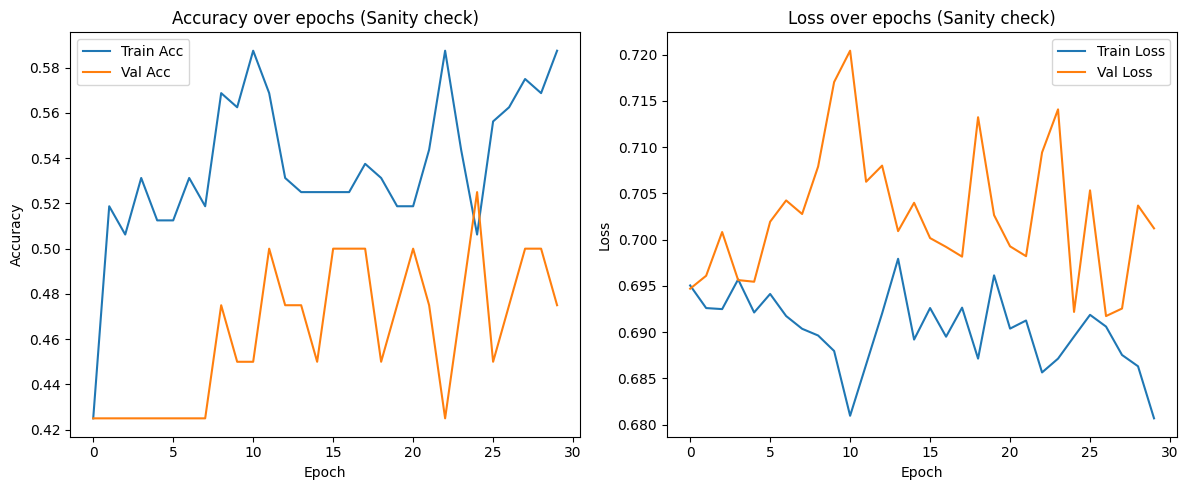

In [1]:
# =====================================
# Sanity Check on 200 samples (EEG LSTM, PyTorch)
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

# -------------------------
# Load data
# -------------------------
focal = pd.read_csv("Bern Barcelona/focal.csv", header=None).values
non_focal = pd.read_csv("Bern Barcelona/non_focal.csv", header=None).values

# Segment into 1s windows (512 samples)
def segment_rows(data, window_size=512):
    segmented = []
    for row in data:
        for i in range(0, len(row), window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented)

focal_seg = segment_rows(focal, 512)
non_focal_seg = segment_rows(non_focal, 512)

# Labels
y_focal = np.ones(len(focal_seg))
y_non_focal = np.zeros(len(non_focal_seg))

# Combine
X = np.vstack((focal_seg, non_focal_seg))
y = np.concatenate((y_focal, y_non_focal))

# Normalize per window
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
X = X[..., np.newaxis]   # (samples, 512, 1)

print("Final X shape:", X.shape, "y shape:", y.shape)

# -------------------------
# Take only 200 samples for sanity check
# -------------------------
X_small, _, y_small, _ = train_test_split(X, y, train_size=200, stratify=y, random_state=42)

# Convert to torch tensors
X_small = torch.tensor(X_small, dtype=torch.float32)
y_small = torch.tensor(y_small, dtype=torch.float32)

# Train/val split
train_size = int(0.8 * len(X_small))
val_size = len(X_small) - train_size
train_data, val_data = random_split(TensorDataset(X_small, y_small), [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

print("Train size:", train_size, "Val size:", val_size)

# -------------------------
# Model: BigBiLSTM
# -------------------------
class BigBiLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[256, 128, 64], num_classes=1):
        super(BigBiLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dims[0], batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2*hidden_dims[0], hidden_dims[1], batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2*hidden_dims[1], hidden_dims[2], batch_first=True, bidirectional=True)

        self.fc1 = nn.Linear(2*hidden_dims[2]*3, 128)  # avg + max + last hidden
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)

        avg_pool = torch.mean(x, dim=1)
        max_pool, _ = torch.max(x, dim=1)
        last_hidden = x[:, -1, :]

        features = torch.cat([avg_pool, max_pool, last_hidden], dim=1)

        x = self.relu(self.fc1(features))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        out = self.fc_out(x)
        return self.sigmoid(out).squeeze(1)

# -------------------------
# Training loop
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BigBiLSTM().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

# -------------------------
# Plot accuracy and loss
# -------------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs (Sanity check)")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs (Sanity check)")
plt.legend()

plt.tight_layout()
plt.show()

NaNs in focal windows: 0
NaNs in non-focal windows: 0


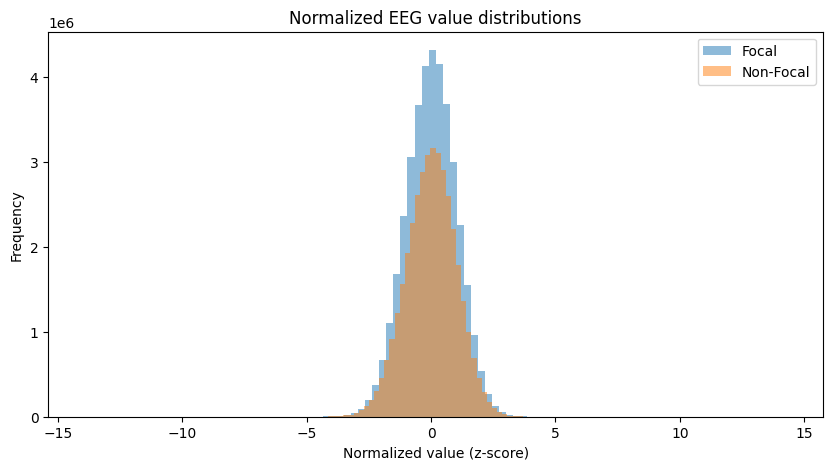

Focal mean/std: 2.423767e-12 1.0
Non-focal mean/std: 5.76543e-11 1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Load data
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = f"{DATA_DIR}/focal.csv"
NON_FOCAL_PATH = f"{DATA_DIR}/non_focal.csv"

focal = pd.read_csv(FOCAL_PATH, header=None).values.astype(np.float32)
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values.astype(np.float32)

WINDOW_SIZE = 512

# -------------------------
# Segment into 1s windows
def segment_rows(data, window_size=WINDOW_SIZE):
    segmented = []
    for row in data:
        L = len(row)
        row = row[: (L // window_size) * window_size]  # truncate tail
        for i in range(0, len(row), window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented, dtype=np.float32)

focal_seg = segment_rows(focal)
non_focal_seg = segment_rows(non_focal)

# -------------------------
# Per-window normalization
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0  # prevent division by zero
    X_norm = (X - means) / stds
    return X_norm

focal_norm = normalize_windows_per_window(focal_seg)
non_focal_norm = normalize_windows_per_window(non_focal_seg)

# -------------------------
# 1. Check for NaNs
print("NaNs in focal windows:", np.isnan(focal_norm).sum())
print("NaNs in non-focal windows:", np.isnan(non_focal_norm).sum())

# -------------------------
# 2. Check distribution overlap
# Flatten all windows for a simple histogram comparison
focal_flat = focal_norm.flatten()
non_focal_flat = non_focal_norm.flatten()

plt.figure(figsize=(10,5))
plt.hist(focal_flat, bins=100, alpha=0.5, label="Focal")
plt.hist(non_focal_flat, bins=100, alpha=0.5, label="Non-Focal")
plt.title("Normalized EEG value distributions")
plt.xlabel("Normalized value (z-score)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Optional: check basic stats
print("Focal mean/std:", focal_flat.mean(), focal_flat.std())
print("Non-focal mean/std:", non_focal_flat.mean(), non_focal_flat.std())


Focal windows shape: (75000, 512)
Non-focal windows shape: (75000, 512)


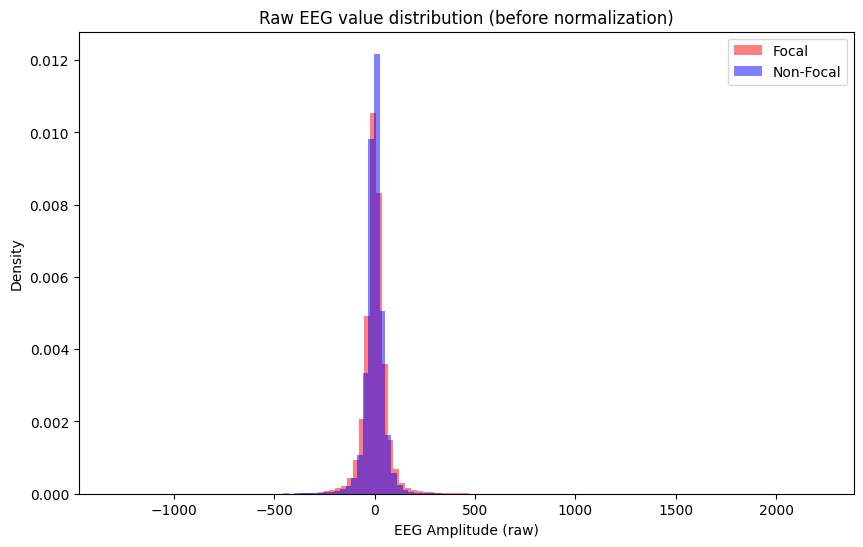

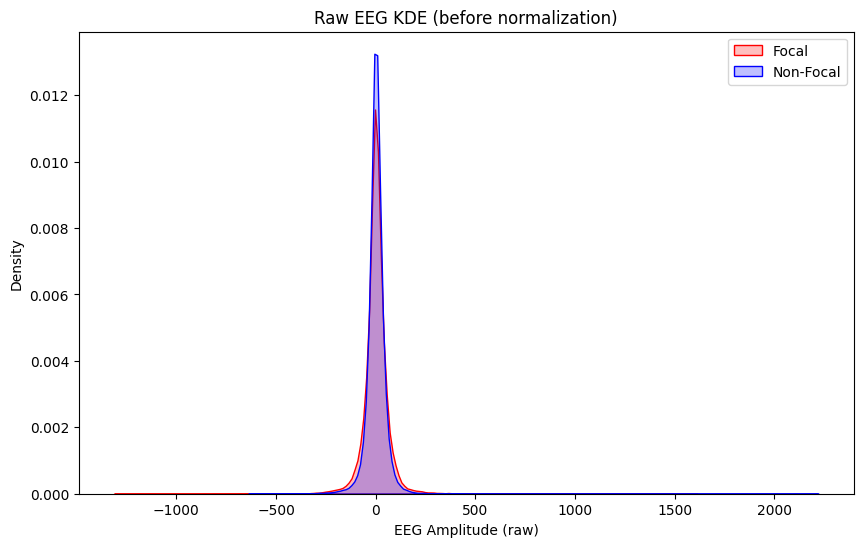

Focal EEG - Mean: 0.1340, Std Dev: 62.8431
Non-Focal EEG - Mean: -0.0769, Std Dev: 49.9379


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
WINDOW_SIZE = 512

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment into 1s windows
def segment_rows(data, window_size=WINDOW_SIZE):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L % window_size != 0:
            row = row[: (L // window_size) * window_size]
        for i in range(0, len(row), window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented, dtype=np.float32)

focal_seg = segment_rows(focal, WINDOW_SIZE)
non_focal_seg = segment_rows(non_focal, WINDOW_SIZE)

print("Focal windows shape:", focal_seg.shape)
print("Non-focal windows shape:", non_focal_seg.shape)


# -------------------------
# Take a smaller subset for plotting (sanity check)
num_samples = 1000
focal_subset = focal_seg[:num_samples].flatten()
non_focal_subset = non_focal_seg[:num_samples].flatten()

# -------------------------
# Plot histogram of raw values
plt.figure(figsize=(10, 6))
plt.hist(focal_subset, bins=100, alpha=0.5, label="Focal", color="red", density=True)
plt.hist(non_focal_subset, bins=100, alpha=0.5, label="Non-Focal", color="blue", density=True)
plt.xlabel("EEG Amplitude (raw)")
plt.ylabel("Density")
plt.title("Raw EEG value distribution (before normalization)")
plt.legend()
plt.show()

# -------------------------
# Optional: Plot KDE (smooth estimate)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(focal_subset, label="Focal", color="red", fill=True)
sns.kdeplot(non_focal_subset, label="Non-Focal", color="blue", fill=True)
plt.xlabel("EEG Amplitude (raw)")
plt.ylabel("Density")
plt.title("Raw EEG KDE (before normalization)")
plt.legend()
plt.show()

# -------------------------
# Compute and print mean and std deviation
focal_mean = np.mean(focal_subset)
focal_std = np.std(focal_subset)

non_focal_mean = np.mean(non_focal_subset)
non_focal_std = np.std(non_focal_subset)

print("Focal EEG - Mean: {:.4f}, Std Dev: {:.4f}".format(focal_mean, focal_std))
print("Non-Focal EEG - Mean: {:.4f}, Std Dev: {:.4f}".format(non_focal_mean, non_focal_std))


Focal shape: (3750, 10240) Non-focal shape: (3750, 10240)


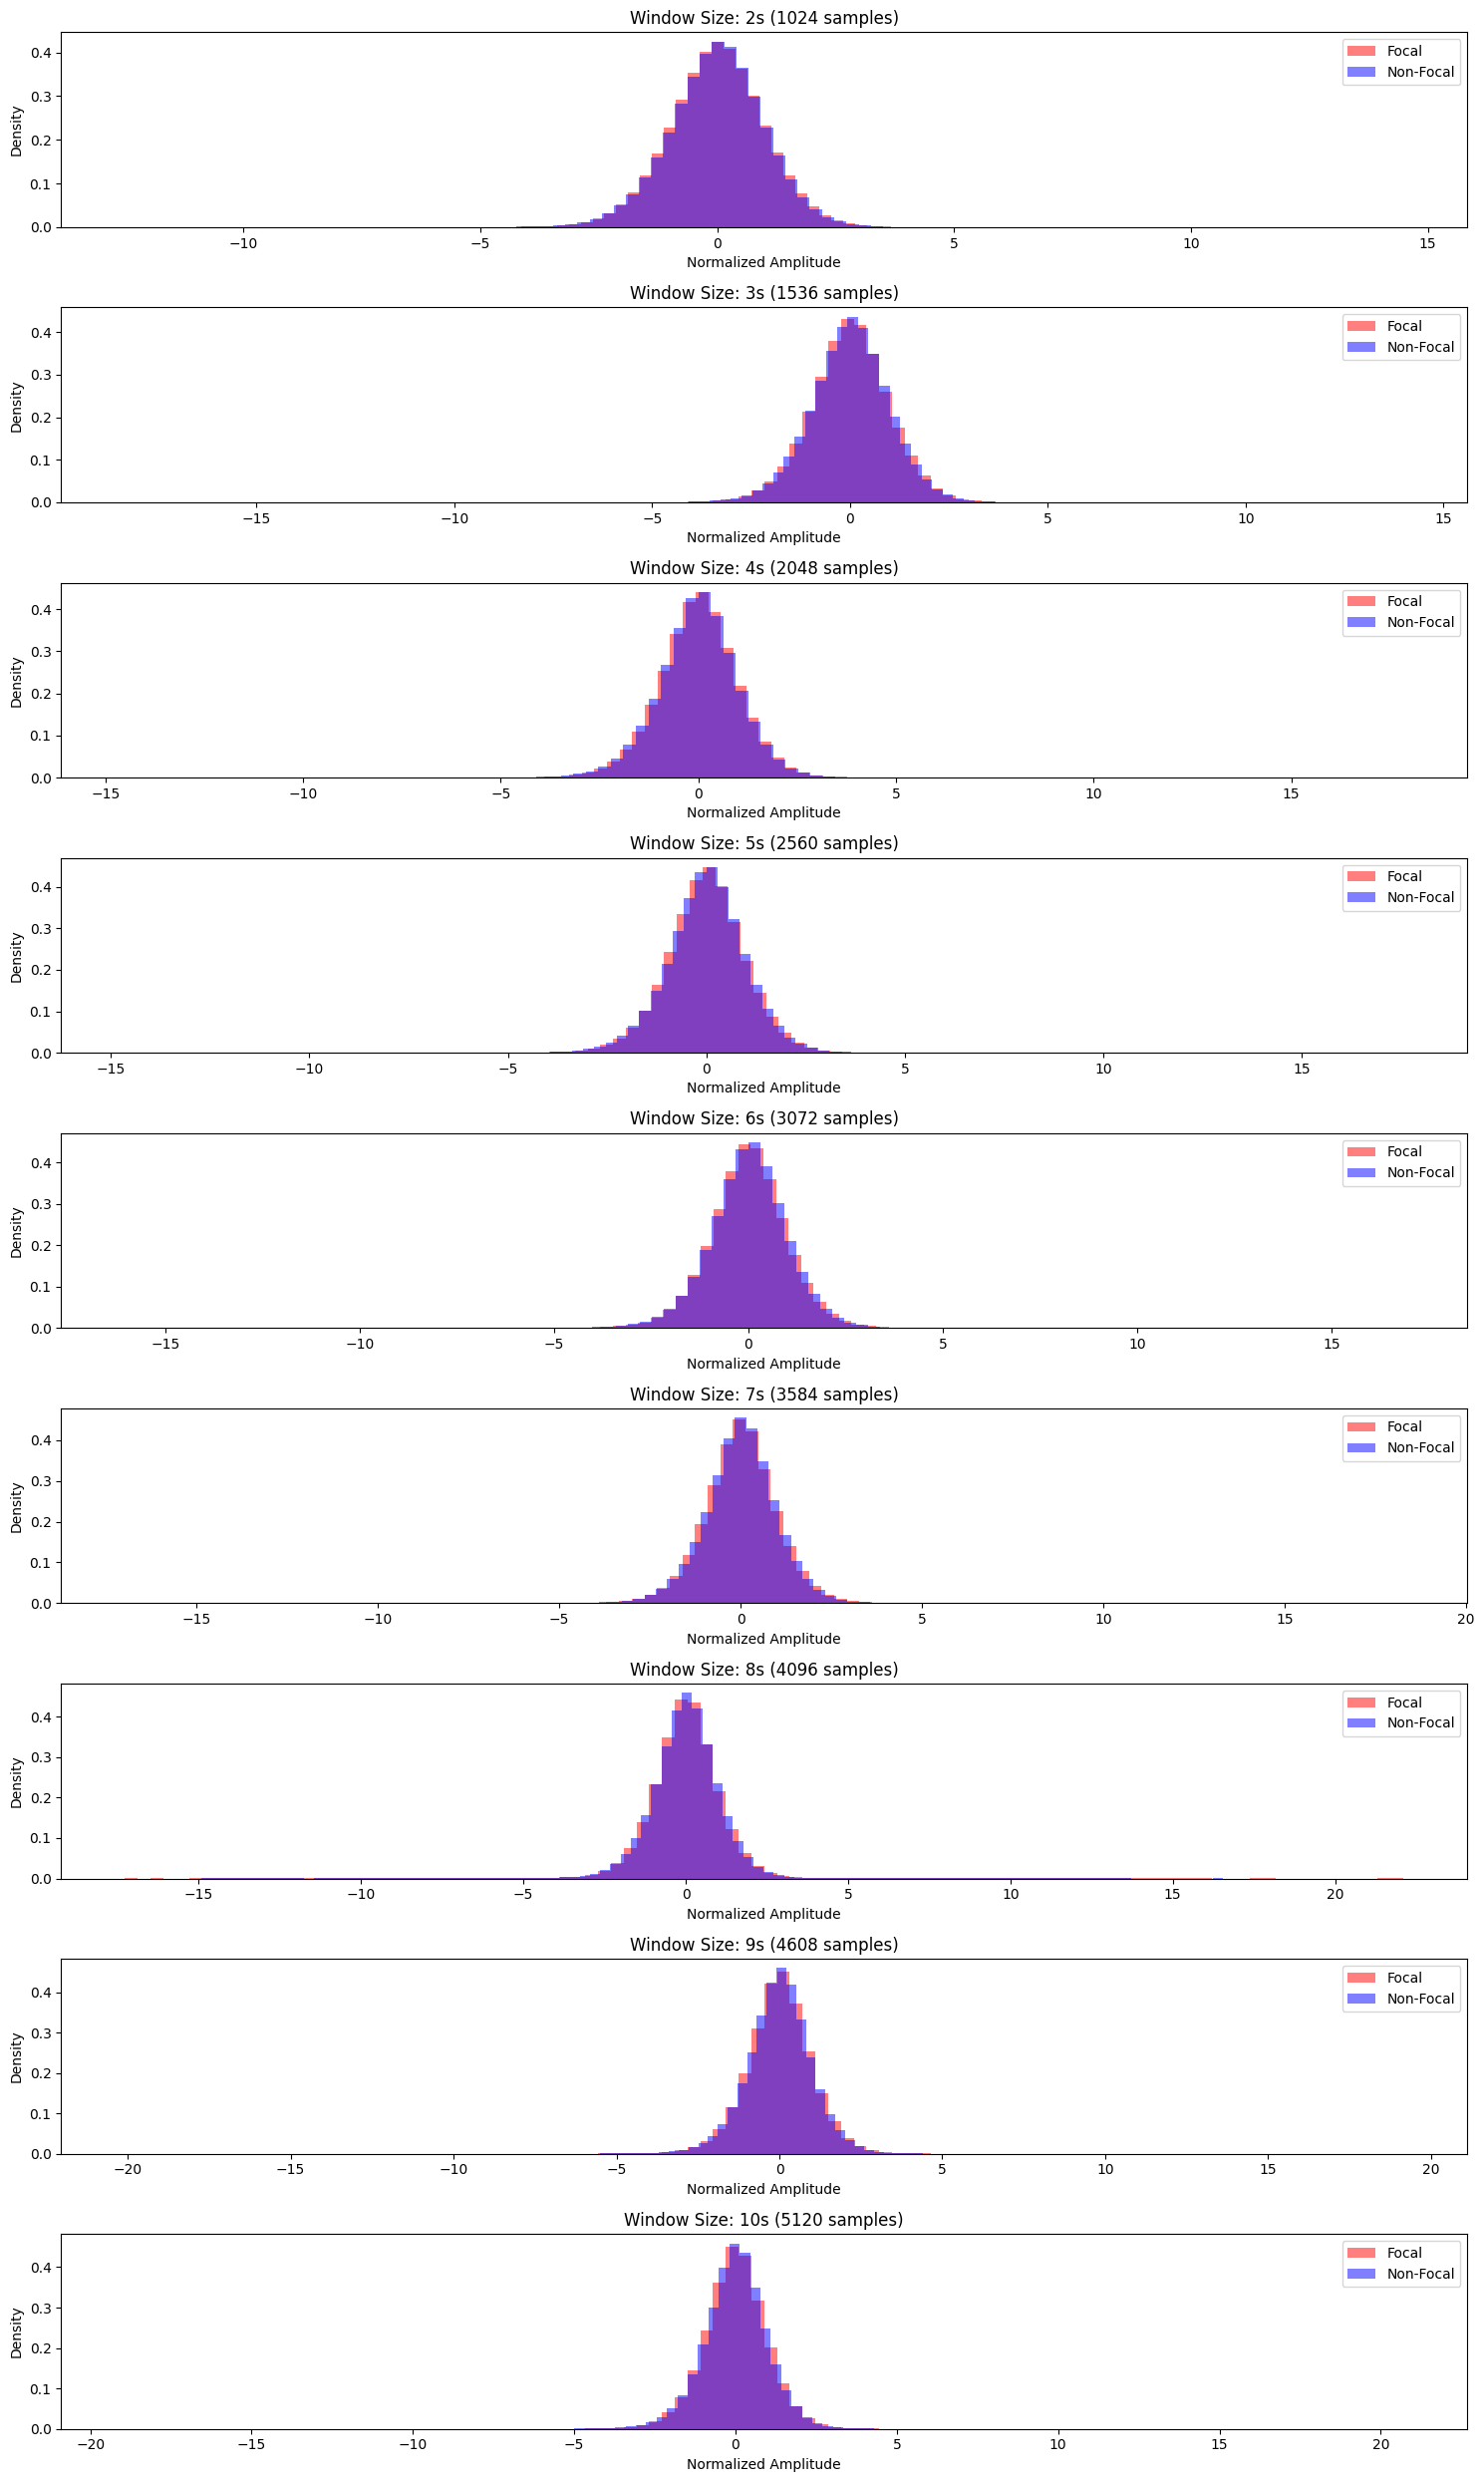

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Paths
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

print("Focal shape:", focal.shape, "Non-focal shape:", non_focal.shape)

# -------------------------
# Function to segment windows
def segment_rows(data, window_size):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L < window_size:
            continue  # skip if row shorter than window
        for i in range(0, L - window_size + 1, window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented, dtype=np.float32)

# -------------------------
# Normalization per window
def normalize_windows(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

# -------------------------
# Window sizes in seconds (sampling rate 512 Hz)
window_sizes_sec = [2,3,4,5,6,7,8,9,10]
fs = 512  # Hz

plt.figure(figsize=(15, 25))

for idx, sec in enumerate(window_sizes_sec):
    win_size = sec * fs
    focal_seg = segment_rows(focal, win_size)
    non_focal_seg = segment_rows(non_focal, win_size)
   
    # Normalize
    focal_norm = normalize_windows(focal_seg)
    non_focal_norm = normalize_windows(non_focal_seg)
   
    # Flatten all windows for histogram
    focal_flat = focal_norm.flatten()
    non_focal_flat = non_focal_norm.flatten()
   
    # Plot histogram
    plt.subplot(len(window_sizes_sec), 1, idx+1)
    plt.hist(focal_flat, bins=100, alpha=0.5, label="Focal", color="red", density=True)
    plt.hist(non_focal_flat, bins=100, alpha=0.5, label="Non-Focal", color="blue", density=True)
    plt.title(f"Window Size: {sec}s ({win_size} samples)")
    plt.xlabel("Normalized Amplitude")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()



Using device: cuda
Epoch 1/30 | Train loss: 0.6669 acc: 0.6500 | Val loss: 0.6784 acc: 1.0000
Epoch 2/30 | Train loss: 0.4951 acc: 1.0000 | Val loss: 0.5396 acc: 1.0000
Epoch 3/30 | Train loss: 0.3095 acc: 1.0000 | Val loss: 0.2956 acc: 1.0000
Epoch 4/30 | Train loss: 0.1543 acc: 1.0000 | Val loss: 0.1241 acc: 1.0000
Epoch 5/30 | Train loss: 0.0743 acc: 1.0000 | Val loss: 0.0561 acc: 1.0000
Epoch 6/30 | Train loss: 0.0398 acc: 1.0000 | Val loss: 0.0306 acc: 1.0000
Epoch 7/30 | Train loss: 0.0238 acc: 1.0000 | Val loss: 0.0191 acc: 1.0000
Epoch 8/30 | Train loss: 0.0158 acc: 1.0000 | Val loss: 0.0134 acc: 1.0000
Epoch 9/30 | Train loss: 0.0116 acc: 1.0000 | Val loss: 0.0103 acc: 1.0000
Epoch 10/30 | Train loss: 0.0091 acc: 1.0000 | Val loss: 0.0082 acc: 1.0000
Epoch 11/30 | Train loss: 0.0075 acc: 1.0000 | Val loss: 0.0069 acc: 1.0000
Epoch 12/30 | Train loss: 0.0063 acc: 1.0000 | Val loss: 0.0058 acc: 1.0000
Epoch 13/30 | Train loss: 0.0053 acc: 1.0000 | Val loss: 0.0050 acc: 1.0000
Ep

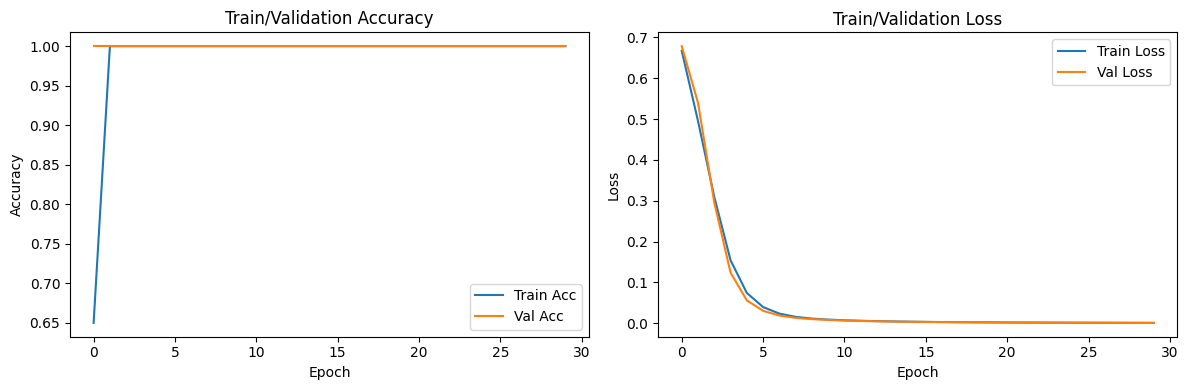

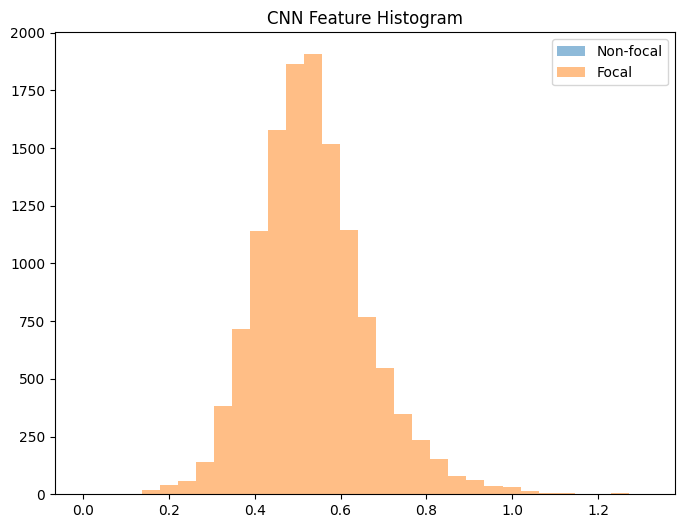

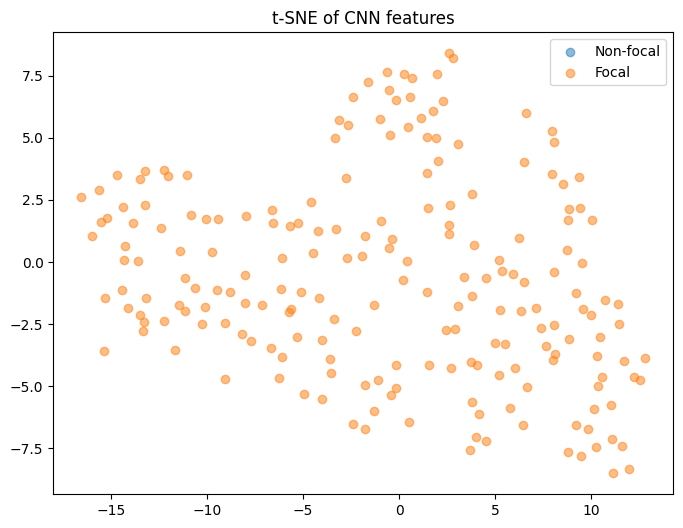

In [10]:
# cnn_bilstm_eeg_sanity.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
WINDOW_SIZE = 512
BATCH_SIZE = 16      # small for sanity check
EPOCHS = 30
LEARNING_RATE = 1e-3
OUTPUT_DIR = "results_cnn_bilstm"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment into 1s windows (512 samples)
def segment_rows(data, window_size=WINDOW_SIZE):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L % window_size != 0:
            row = row[: (L // window_size) * window_size]
        for i in range(0, len(row), window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented, dtype=np.float32)

focal_seg = segment_rows(focal, WINDOW_SIZE)
non_focal_seg = segment_rows(non_focal, WINDOW_SIZE)

# -------------------------
# Labels and combine
y_focal = np.ones(len(focal_seg), dtype=np.int64)
y_non_focal = np.zeros(len(non_focal_seg), dtype=np.int64)
X_all = np.vstack((focal_seg, non_focal_seg)).astype(np.float32)
y_all = np.concatenate((y_focal, y_non_focal)).astype(np.int64)

# -------------------------
# Per-window normalization
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds==0] = 1.0
    return (X - means) / stds

X_all = normalize_windows_per_window(X_all)

# -------------------------
# Sanity check subset (small number of examples)
N_EXAMPLES = 200
X_small = X_all[:N_EXAMPLES]
y_small = y_all[:N_EXAMPLES]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = np.expand_dims(self.X[idx], axis=0)  # add channel dim
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

train_ds = EEGDataset(X_train, y_train)
val_ds = EEGDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # compute LSTM input size
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=32,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(32*2, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (batch, 1, seq_len)
        x = self.cnn(x)  # (batch, channels, seq_len')
        x = x.permute(0, 2, 1)  # (batch, seq_len', channels) for LSTM
        _, (hn, _) = self.lstm(x)
        h = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        out = self.fc(h)
        return out.squeeze()

# -------------------------
# Feature extraction helper
def extract_cnn_features(model, X):
    model.eval()
    X_tensor = torch.tensor(np.expand_dims(X, axis=1), dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        features = model.cnn(X_tensor).permute(0,2,1).mean(dim=1).cpu().numpy()
    return features

# -------------------------
# Training function
def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
   
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        # Train
        model.train()
        train_losses = []
        y_true_train, y_pred_train = [], []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            y_true_train.extend(y_batch.cpu().numpy())
            y_pred_train.extend((outputs.detach().cpu().numpy()>=0.5).astype(int))
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = np.mean(train_losses)

        # Validate
        model.eval()
        val_losses = []
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())
                y_true_val.extend(y_batch.cpu().numpy())
                y_pred_val.extend((outputs.cpu().numpy()>=0.5).astype(int))
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch}/{epochs} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    return history

# -------------------------
# Initialize model and train
model = CNN_BiLSTM().to(DEVICE)
history = train_model(model, train_loader, val_loader, epochs=EPOCHS)

# -------------------------
# Plot train/val accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train/Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train/Validation Loss")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"train_val_plots.png"))
plt.show()

# -------------------------
# CNN feature visualization
features = extract_cnn_features(model, X_small)
plt.figure(figsize=(8,6))
plt.hist(features[y_small==0].flatten(), bins=30, alpha=0.5, label="Non-focal")
plt.hist(features[y_small==1].flatten(), bins=30, alpha=0.5, label="Focal")
plt.legend()
plt.title("CNN Feature Histogram")
plt.savefig(os.path.join(OUTPUT_DIR,"cnn_feature_hist.png"))
plt.show()

# Optional: t-SNE of CNN features
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
plt.figure(figsize=(8,6))
plt.scatter(features_2d[y_small==0,0], features_2d[y_small==0,1], alpha=0.5, label="Non-focal")
plt.scatter(features_2d[y_small==1,0], features_2d[y_small==1,1], alpha=0.5, label="Focal")
plt.legend()
plt.title("t-SNE of CNN features")
plt.savefig(os.path.join(OUTPUT_DIR,"cnn_feature_tsne.png"))
plt.show()



Using device: cuda
Epoch 1: Train Acc 0.5000, Val Acc 0.5000, Train Loss 0.6996, Val Loss 0.6976
Epoch 2: Train Acc 0.5000, Val Acc 0.5000, Train Loss 0.6976, Val Loss 0.6950
Epoch 3: Train Acc 0.5050, Val Acc 0.5100, Train Loss 0.6938, Val Loss 0.6937
Epoch 4: Train Acc 0.5050, Val Acc 0.5200, Train Loss 0.6920, Val Loss 0.6931
Epoch 5: Train Acc 0.5225, Val Acc 0.5600, Train Loss 0.6906, Val Loss 0.6930
Epoch 6: Train Acc 0.5550, Val Acc 0.5700, Train Loss 0.6897, Val Loss 0.6908
Epoch 7: Train Acc 0.5775, Val Acc 0.5200, Train Loss 0.6868, Val Loss 0.6922
Epoch 8: Train Acc 0.5750, Val Acc 0.5400, Train Loss 0.6807, Val Loss 0.6878
Epoch 9: Train Acc 0.5875, Val Acc 0.4700, Train Loss 0.6746, Val Loss 0.7194
Epoch 10: Train Acc 0.6175, Val Acc 0.5300, Train Loss 0.6612, Val Loss 0.6856
Epoch 11: Train Acc 0.6350, Val Acc 0.5600, Train Loss 0.6489, Val Loss 0.7064
Epoch 12: Train Acc 0.6500, Val Acc 0.5700, Train Loss 0.6356, Val Loss 0.7014
Epoch 13: Train Acc 0.6175, Val Acc 0.6500

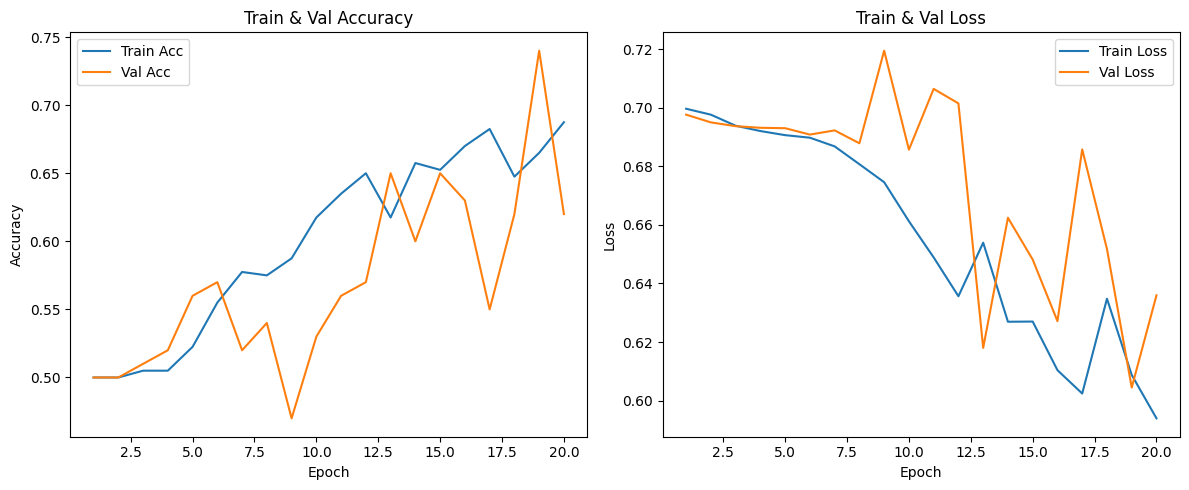

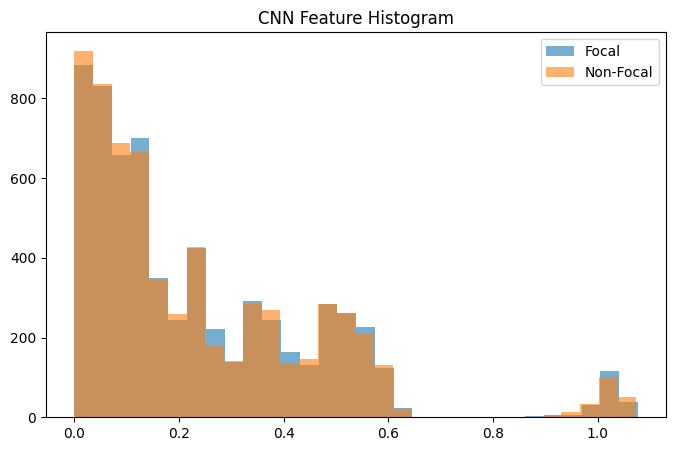

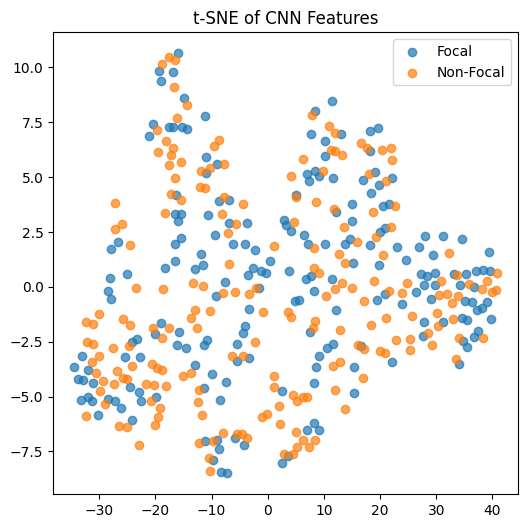

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
WINDOW_SIZE = 512
N_EXAMPLES_PER_CLASS = 250  # total 500
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment rows
def segment_rows(data, window_size=WINDOW_SIZE):
    seg = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        row = row[: (L // window_size) * window_size]
        for i in range(0, len(row), window_size):
            seg.append(row[i:i+window_size])
    return np.array(seg, dtype=np.float32)

focal_seg = segment_rows(focal)
non_focal_seg = segment_rows(non_focal)

# -------------------------
# Take balanced subset
X_focal_small = focal_seg[:N_EXAMPLES_PER_CLASS]
X_nonfocal_small = non_focal_seg[:N_EXAMPLES_PER_CLASS]

y_focal_small = np.ones(N_EXAMPLES_PER_CLASS)
y_nonfocal_small = np.zeros(N_EXAMPLES_PER_CLASS)

X_small = np.vstack([X_focal_small, X_nonfocal_small])
y_small = np.concatenate([y_focal_small, y_nonfocal_small])

# Shuffle
idx = np.arange(len(y_small))
np.random.shuffle(idx)
X_small = X_small[idx]
y_small = y_small[idx]

# -------------------------
# Normalize per window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means)/stds

X_small_norm = normalize_windows_per_window(X_small)

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = np.expand_dims(self.X[idx], axis=0)  # add channel
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X_small_norm, y_small, test_size=0.2, random_state=42, stratify=y_small
)

train_ds = EEGDataset(X_train, y_train)
val_ds   = EEGDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# CNN + BiLSTM Model
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, num_layers=1,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(32*2, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (batch, channel=1, seq_len)
        x = self.cnn(x)          # (batch, channels, seq_len/2)
        x = x.permute(0,2,1)     # (batch, seq_len/2, channels)
        _, (hn, _) = self.lstm(x)
        x = torch.cat((hn[-2], hn[-1]), dim=1)
        x = self.fc(x)
        return x.squeeze()

model = CNN_BiLSTM().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -------------------------
# Training loop
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    running_loss, preds, labels = 0, [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds.append(out.detach().cpu())
        labels.append(y_batch.detach().cpu())
    train_loss = running_loss / len(train_ds)
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    train_acc = accuracy_score(labels, (preds>=0.5).astype(int))

    # Val
    model.eval()
    running_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds.append(out.cpu())
            labels.append(y_batch.cpu())
    val_loss = running_loss / len(val_ds)
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    val_acc = accuracy_score(labels, (preds>=0.5).astype(int))

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch}: Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}, Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

# -------------------------
# Plot train/val accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1), train_acc_list, label="Train Acc")
plt.plot(range(1,EPOCHS+1), val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train & Val Accuracy")

plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1), train_loss_list, label="Train Loss")
plt.plot(range(1,EPOCHS+1), val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Val Loss")
plt.tight_layout()
plt.show()

# -------------------------
# Extract CNN features for histogram & t-SNE
model.eval()
features = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(DEVICE)
        x = model.cnn(X_batch)
        x = x.mean(dim=2)  # global average pooling
        features.append(x.cpu())
features = torch.cat(features).numpy()

# Histogram
plt.figure(figsize=(8,5))
plt.hist(features[y_train==1].flatten(), bins=30, alpha=0.6, label="Focal")
plt.hist(features[y_train==0].flatten(), bins=30, alpha=0.6, label="Non-Focal")
plt.legend()
plt.title("CNN Feature Histogram")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
plt.figure(figsize=(6,6))
plt.scatter(features_2d[y_train==1,0], features_2d[y_train==1,1], label="Focal", alpha=0.7)
plt.scatter(features_2d[y_train==0,0], features_2d[y_train==0,1], label="Non-Focal", alpha=0.7)
plt.legend()
plt.title("t-SNE of CNN Features")
plt.show()

Using device: cuda
Epoch 1/25 - Train Acc: 0.497, Val Acc: 0.500, Train Loss: 0.694, Val Loss: 0.694
Epoch 2/25 - Train Acc: 0.497, Val Acc: 0.550, Train Loss: 0.693, Val Loss: 0.693
Epoch 3/25 - Train Acc: 0.547, Val Acc: 0.510, Train Loss: 0.691, Val Loss: 0.695
Epoch 4/25 - Train Acc: 0.530, Val Acc: 0.440, Train Loss: 0.693, Val Loss: 0.698
Epoch 5/25 - Train Acc: 0.540, Val Acc: 0.450, Train Loss: 0.691, Val Loss: 0.694
Epoch 6/25 - Train Acc: 0.537, Val Acc: 0.470, Train Loss: 0.690, Val Loss: 0.695
Epoch 7/25 - Train Acc: 0.540, Val Acc: 0.460, Train Loss: 0.691, Val Loss: 0.697
Epoch 8/25 - Train Acc: 0.547, Val Acc: 0.470, Train Loss: 0.690, Val Loss: 0.700
Epoch 9/25 - Train Acc: 0.557, Val Acc: 0.470, Train Loss: 0.687, Val Loss: 0.701
Epoch 10/25 - Train Acc: 0.530, Val Acc: 0.460, Train Loss: 0.689, Val Loss: 0.696
Epoch 11/25 - Train Acc: 0.545, Val Acc: 0.500, Train Loss: 0.685, Val Loss: 0.695
Epoch 12/25 - Train Acc: 0.502, Val Acc: 0.520, Train Loss: 0.705, Val Loss: 

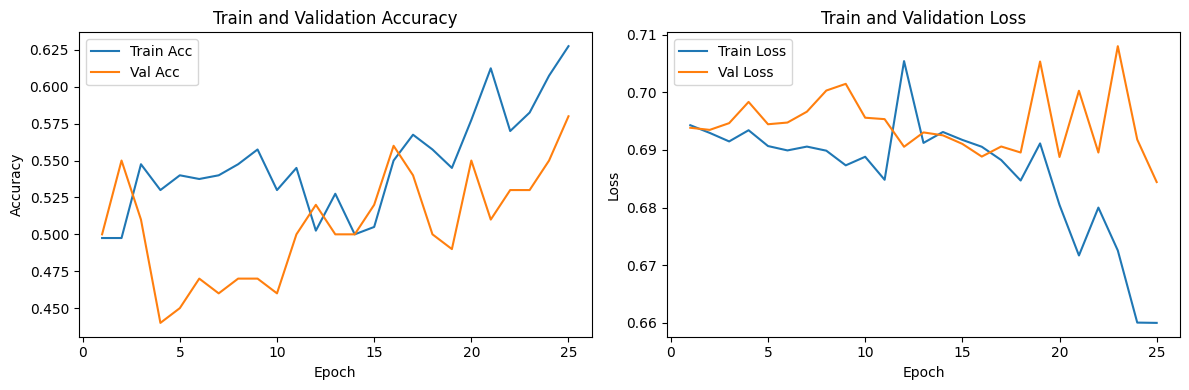

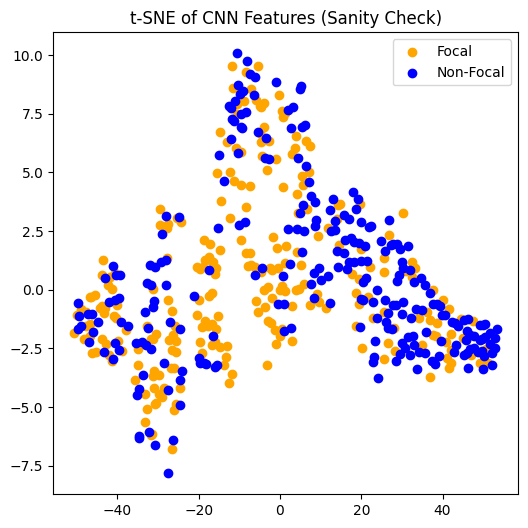

In [12]:
# sanity_check_cnn_bilstm.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# Params
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
WINDOW_SIZE = 512   # 1s window
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-3
OUTPUT_DIR = "results_cnn_bilstm_sanity"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------
# Load and sample data (500 examples balanced)
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# Segment into 1s windows
def segment_rows(data, window_size=WINDOW_SIZE):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        row = row[: (L // window_size) * window_size]
        for i in range(0, len(row), window_size):
            segmented.append(row[i:i+window_size])
    return np.array(segmented, dtype=np.float32)

focal_seg = segment_rows(focal, WINDOW_SIZE)
non_focal_seg = segment_rows(non_focal, WINDOW_SIZE)

# Randomly sample 250 from each class
np.random.seed(42)
idx_focal = np.random.choice(len(focal_seg), 250, replace=False)
idx_non_focal = np.random.choice(len(non_focal_seg), 250, replace=False)
X_sample = np.vstack((focal_seg[idx_focal], non_focal_seg[idx_non_focal]))
y_sample = np.concatenate((np.ones(250), np.zeros(250)))

# -------------------------
# Normalize per-window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

X_sample = normalize_windows_per_window(X_sample)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = np.expand_dims(self.X[idx], axis=0)  # (1, seq_len)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

train_ds = EEGDataset(X_train, y_train)
val_ds = EEGDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# CNN + BiLSTM Model
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.bilstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        self.fc = nn.Sequential(
            nn.Linear(64*2, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (batch, 1, seq_len)
        x = self.cnn(x)                # (batch, 128, seq_len)
        x = x.permute(0,2,1)           # (batch, seq_len, 128)
        _, (hn, _) = self.bilstm(x)    # hn: (num_layers*2, batch, hidden)
        x = torch.cat((hn[-2], hn[-1]), dim=1)
        x = self.fc(x)
        return x.squeeze()

model = CNN_BiLSTM().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -------------------------
# Training loop
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        all_preds.append(outputs.detach().cpu())
        all_labels.append(y_batch.cpu())
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    train_acc = accuracy_score(all_labels, (all_preds>=0.5).astype(int))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(outputs.cpu())
            all_labels.append(y_batch.cpu())
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    val_acc = accuracy_score(all_labels, (all_preds>=0.5).astype(int))
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} - Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, "
          f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

# -------------------------
# Plot accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1), train_accs, label="Train Acc")
plt.plot(range(1,EPOCHS+1), val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1,EPOCHS+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sanity_check_plot.png"))
plt.show()

# -------------------------
# Extract CNN features for t-SNE
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(np.expand_dims(X_sample,1),dtype=torch.float32).to(DEVICE)
    cnn_features = model.cnn(X_tensor).permute(0,2,1).mean(dim=1).cpu().numpy()  # average pooling over seq_len

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(cnn_features)

plt.figure(figsize=(6,6))
plt.scatter(features_2d[y_sample==1,0], features_2d[y_sample==1,1], c='orange', label='Focal')
plt.scatter(features_2d[y_sample==0,0], features_2d[y_sample==0,1], c='blue', label='Non-Focal')
plt.legend()
plt.title("t-SNE of CNN Features (Sanity Check)")
plt.savefig(os.path.join(OUTPUT_DIR, "tsne_cnn_features.png"))
plt.show()


=== Window: 3s (1536 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.52
Epoch 2: train_acc=0.59, val_acc=0.55
Epoch 3: train_acc=0.61, val_acc=0.57
Epoch 4: train_acc=0.63, val_acc=0.58
Epoch 5: train_acc=0.64, val_acc=0.52
Epoch 6: train_acc=0.64, val_acc=0.48
Epoch 7: train_acc=0.64, val_acc=0.48
Epoch 8: train_acc=0.69, val_acc=0.47
Epoch 9: train_acc=0.71, val_acc=0.48
Epoch 10: train_acc=0.72, val_acc=0.48


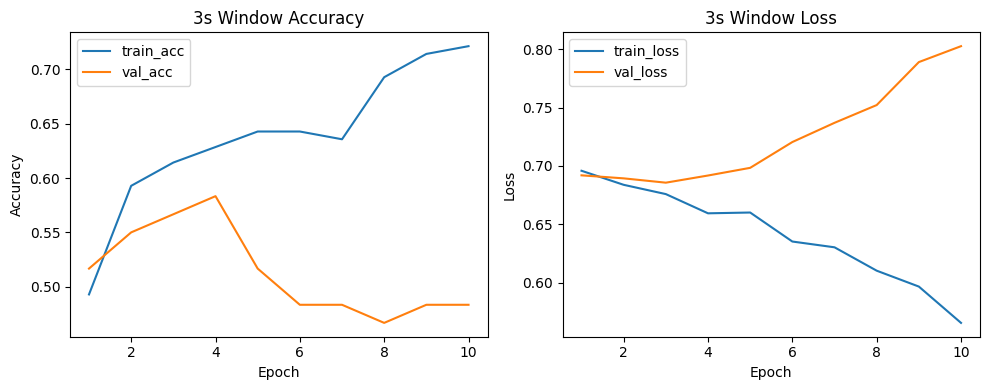


=== Window: 4s (2048 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.50
Epoch 2: train_acc=0.50, val_acc=0.50
Epoch 3: train_acc=0.49, val_acc=0.40
Epoch 4: train_acc=0.52, val_acc=0.42
Epoch 5: train_acc=0.54, val_acc=0.45
Epoch 6: train_acc=0.58, val_acc=0.52
Epoch 7: train_acc=0.55, val_acc=0.55
Epoch 8: train_acc=0.61, val_acc=0.57
Epoch 9: train_acc=0.61, val_acc=0.53
Epoch 10: train_acc=0.58, val_acc=0.57


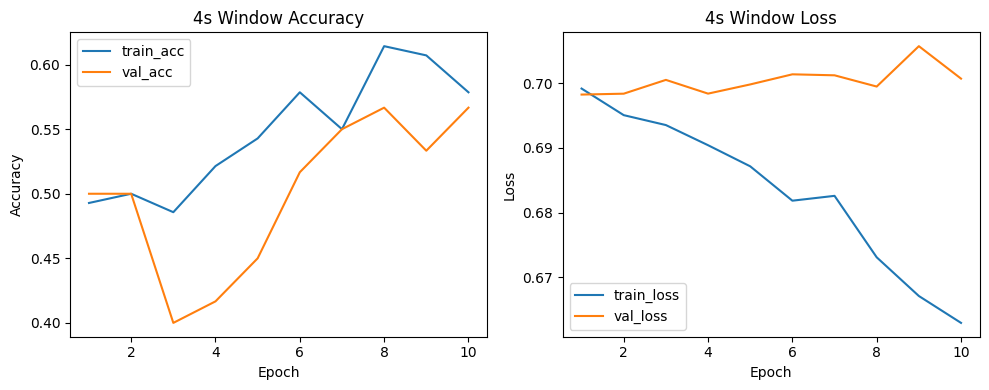


=== Window: 5s (2560 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.48
Epoch 2: train_acc=0.58, val_acc=0.48
Epoch 3: train_acc=0.59, val_acc=0.48
Epoch 4: train_acc=0.59, val_acc=0.47
Epoch 5: train_acc=0.60, val_acc=0.48
Epoch 6: train_acc=0.61, val_acc=0.48
Epoch 7: train_acc=0.61, val_acc=0.42
Epoch 8: train_acc=0.62, val_acc=0.47
Epoch 9: train_acc=0.66, val_acc=0.43
Epoch 10: train_acc=0.71, val_acc=0.47


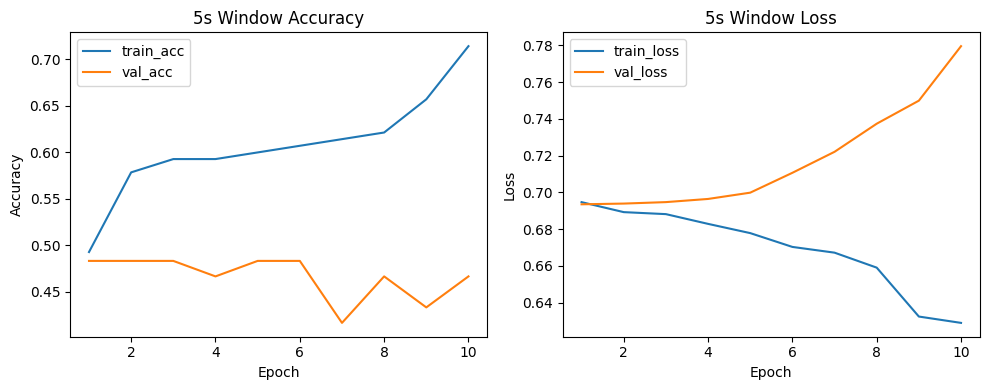


=== Window: 6s (3072 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.57
Epoch 2: train_acc=0.57, val_acc=0.57
Epoch 3: train_acc=0.57, val_acc=0.57
Epoch 4: train_acc=0.59, val_acc=0.58
Epoch 5: train_acc=0.58, val_acc=0.50
Epoch 6: train_acc=0.60, val_acc=0.53
Epoch 7: train_acc=0.56, val_acc=0.57
Epoch 8: train_acc=0.56, val_acc=0.57
Epoch 9: train_acc=0.57, val_acc=0.63
Epoch 10: train_acc=0.64, val_acc=0.58


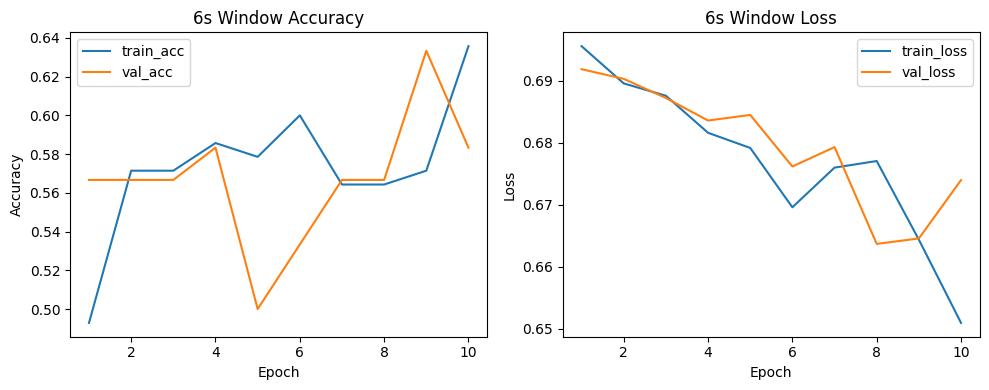


=== Window: 7s (3584 samples) ===
Epoch 1: train_acc=0.46, val_acc=0.50
Epoch 2: train_acc=0.59, val_acc=0.52
Epoch 3: train_acc=0.57, val_acc=0.57
Epoch 4: train_acc=0.60, val_acc=0.53
Epoch 5: train_acc=0.59, val_acc=0.53
Epoch 6: train_acc=0.57, val_acc=0.62
Epoch 7: train_acc=0.60, val_acc=0.55
Epoch 8: train_acc=0.62, val_acc=0.60
Epoch 9: train_acc=0.63, val_acc=0.63
Epoch 10: train_acc=0.66, val_acc=0.58


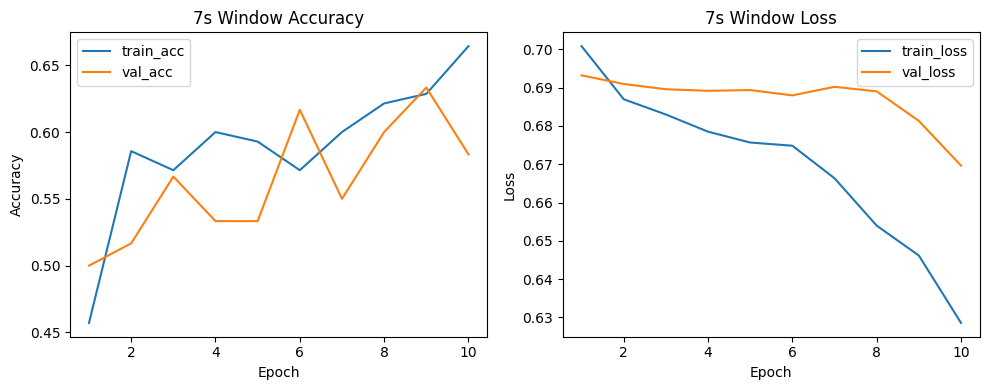


=== Window: 8s (4096 samples) ===
Epoch 1: train_acc=0.44, val_acc=0.50
Epoch 2: train_acc=0.51, val_acc=0.50
Epoch 3: train_acc=0.55, val_acc=0.57
Epoch 4: train_acc=0.56, val_acc=0.60
Epoch 5: train_acc=0.56, val_acc=0.57
Epoch 6: train_acc=0.58, val_acc=0.55
Epoch 7: train_acc=0.61, val_acc=0.55
Epoch 8: train_acc=0.60, val_acc=0.55
Epoch 9: train_acc=0.62, val_acc=0.58
Epoch 10: train_acc=0.63, val_acc=0.57


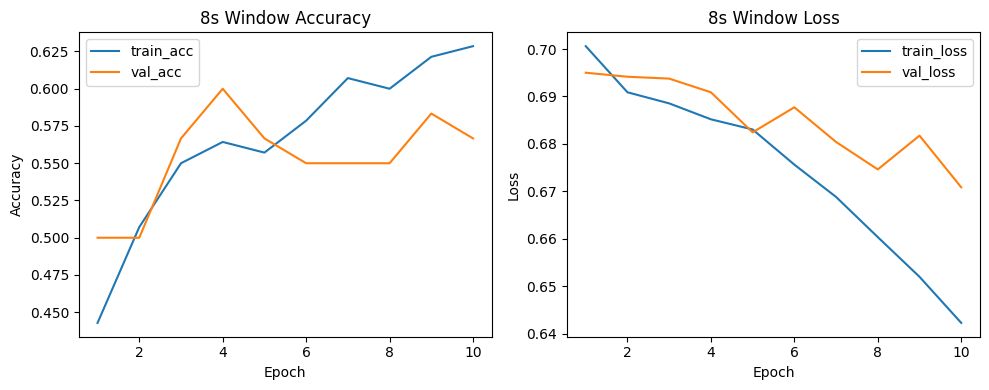


=== Window: 9s (4608 samples) ===
Epoch 1: train_acc=0.50, val_acc=0.50
Epoch 2: train_acc=0.51, val_acc=0.55
Epoch 3: train_acc=0.59, val_acc=0.58
Epoch 4: train_acc=0.61, val_acc=0.58
Epoch 5: train_acc=0.66, val_acc=0.50
Epoch 6: train_acc=0.69, val_acc=0.55
Epoch 7: train_acc=0.69, val_acc=0.58
Epoch 8: train_acc=0.72, val_acc=0.62
Epoch 9: train_acc=0.70, val_acc=0.60
Epoch 10: train_acc=0.72, val_acc=0.62


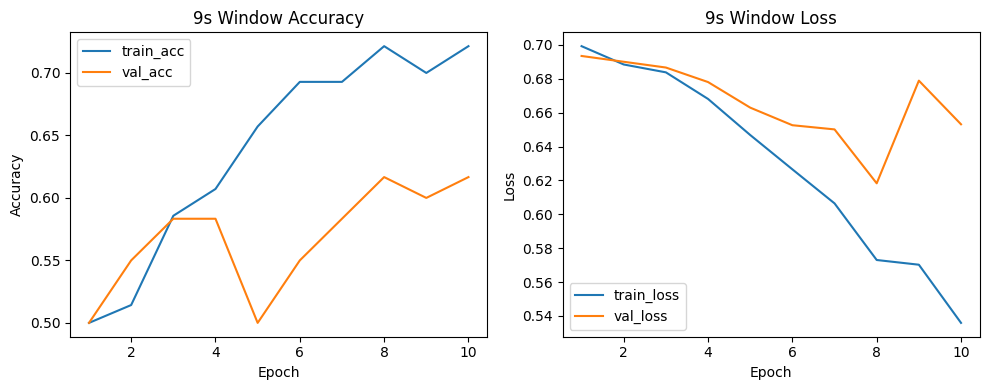


=== Window: 10s (5120 samples) ===
Epoch 1: train_acc=0.46, val_acc=0.50
Epoch 2: train_acc=0.54, val_acc=0.53
Epoch 3: train_acc=0.51, val_acc=0.47
Epoch 4: train_acc=0.58, val_acc=0.45
Epoch 5: train_acc=0.61, val_acc=0.45
Epoch 6: train_acc=0.58, val_acc=0.50
Epoch 7: train_acc=0.67, val_acc=0.47
Epoch 8: train_acc=0.65, val_acc=0.48
Epoch 9: train_acc=0.62, val_acc=0.48
Epoch 10: train_acc=0.68, val_acc=0.48


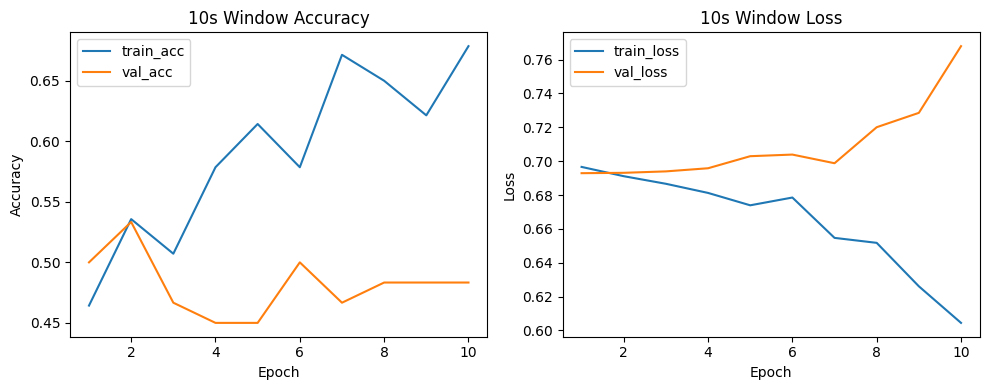

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
SAMPLING_RATE = 512
WINDOW_SECONDS_LIST = list(range(3, 11))  # 3s to 10s
EXAMPLES_PER_CLASS = 100  # 200 examples total
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment function
def segment_rows(data, window_size):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L < window_size:
            continue
        start = np.random.randint(0, L - window_size + 1)  # random segment for sanity check
        segmented.append(row[start:start+window_size])
    return np.array(segmented, dtype=np.float32)

# -------------------------
# Normalize per-window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx][np.newaxis, :]  # (1, seq_len)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# -------------------------
# CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64*2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, channels=1, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last timestep
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x.squeeze()

# -------------------------
# Training & evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    preds, labels = [], []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds.append(out.detach().cpu())
        labels.append(y_batch.detach().cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds>=0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds.append(out.cpu())
            labels.append(y_batch.cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds>=0.5).astype(int))
    return running_loss / len(loader.dataset), acc

# -------------------------
# Loop over window sizes
results = {}
for sec in WINDOW_SECONDS_LIST:
    window_len = sec * SAMPLING_RATE
    print(f"\n=== Window: {sec}s ({window_len} samples) ===")
    focal_seg = segment_rows(focal, window_len)
    non_focal_seg = segment_rows(non_focal, window_len)
   
    # Shuffle and select 100 examples per class
    idx_f = np.random.permutation(len(focal_seg))[:EXAMPLES_PER_CLASS]
    idx_nf = np.random.permutation(len(non_focal_seg))[:EXAMPLES_PER_CLASS]
    X = np.vstack((focal_seg[idx_f], non_focal_seg[idx_nf]))
    y = np.array([1]*EXAMPLES_PER_CLASS + [0]*EXAMPLES_PER_CLASS)
   
    # Shuffle dataset
    perm = np.random.permutation(len(y))
    X, y = X[perm], y[perm]
   
    X = normalize_windows_per_window(X)
   
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    train_ds = EEGDataset(X_train, y_train)
    val_ds = EEGDataset(X_val, y_val)
   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
   
    model = CNN_BiLSTM(input_len=window_len).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
   
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print(f"Epoch {epoch}: train_acc={train_acc:.2f}, val_acc={val_acc:.2f}")
   
    # Store results
    results[sec] = {
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "train_loss": train_loss_list,
        "val_loss": val_loss_list
    }
   
    # Plot
    epochs_range = range(1, EPOCHS+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_acc_list, label="train_acc")
    plt.plot(epochs_range, val_acc_list, label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{sec}s Window Accuracy")
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_loss_list, label="train_loss")
    plt.plot(epochs_range, val_loss_list, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{sec}s Window Loss")
    plt.legend()
   
    plt.tight_layout()
    plt.show()




=== Window: 3s (1536 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.52
Epoch 2: train_acc=0.59, val_acc=0.55
Epoch 3: train_acc=0.61, val_acc=0.57
Epoch 4: train_acc=0.63, val_acc=0.58
Epoch 5: train_acc=0.64, val_acc=0.52
Epoch 6: train_acc=0.64, val_acc=0.48
Epoch 7: train_acc=0.64, val_acc=0.48
Epoch 8: train_acc=0.69, val_acc=0.47
Epoch 9: train_acc=0.71, val_acc=0.48
Epoch 10: train_acc=0.72, val_acc=0.48


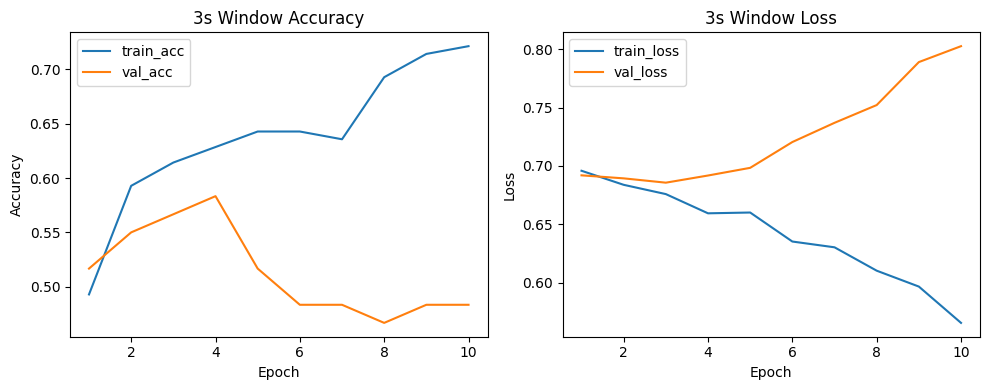

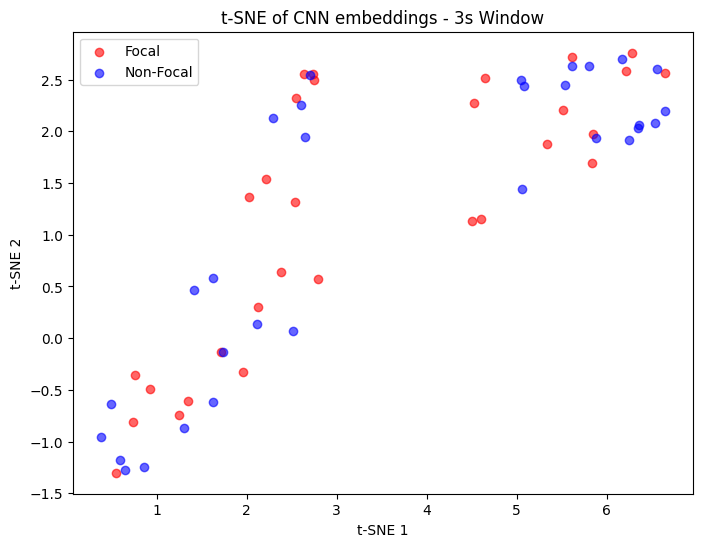


=== Window: 4s (2048 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.52
Epoch 2: train_acc=0.53, val_acc=0.43
Epoch 3: train_acc=0.53, val_acc=0.47
Epoch 4: train_acc=0.53, val_acc=0.47
Epoch 5: train_acc=0.54, val_acc=0.48
Epoch 6: train_acc=0.56, val_acc=0.52
Epoch 7: train_acc=0.58, val_acc=0.55
Epoch 8: train_acc=0.60, val_acc=0.58
Epoch 9: train_acc=0.57, val_acc=0.55
Epoch 10: train_acc=0.64, val_acc=0.55


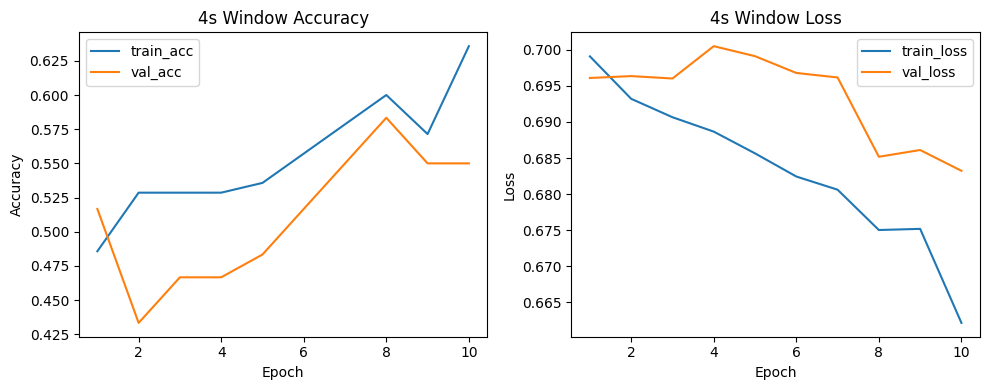

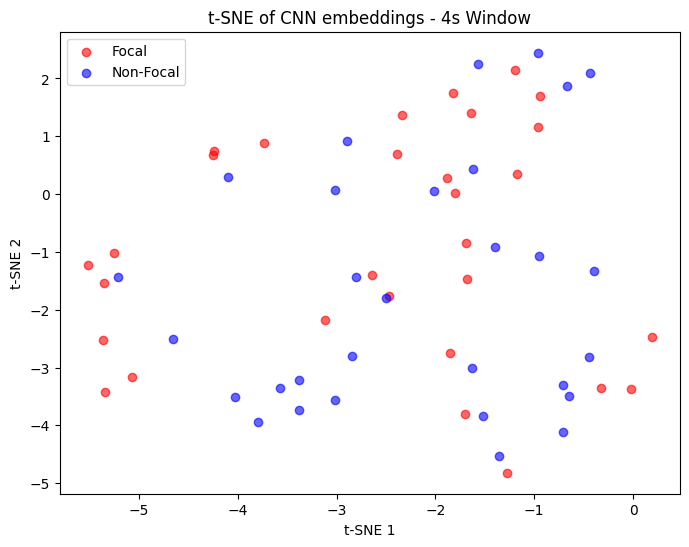


=== Window: 5s (2560 samples) ===
Epoch 1: train_acc=0.49, val_acc=0.50
Epoch 2: train_acc=0.54, val_acc=0.50
Epoch 3: train_acc=0.59, val_acc=0.52
Epoch 4: train_acc=0.56, val_acc=0.55
Epoch 5: train_acc=0.61, val_acc=0.50
Epoch 6: train_acc=0.62, val_acc=0.52
Epoch 7: train_acc=0.64, val_acc=0.47
Epoch 8: train_acc=0.63, val_acc=0.45
Epoch 9: train_acc=0.66, val_acc=0.45
Epoch 10: train_acc=0.72, val_acc=0.42


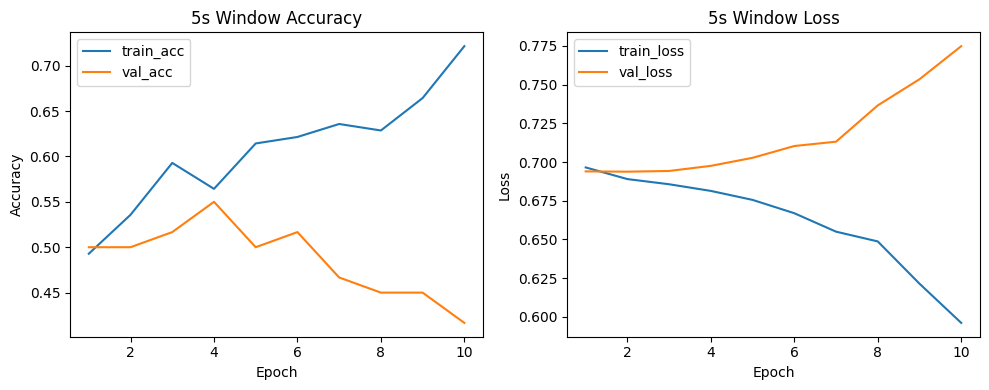

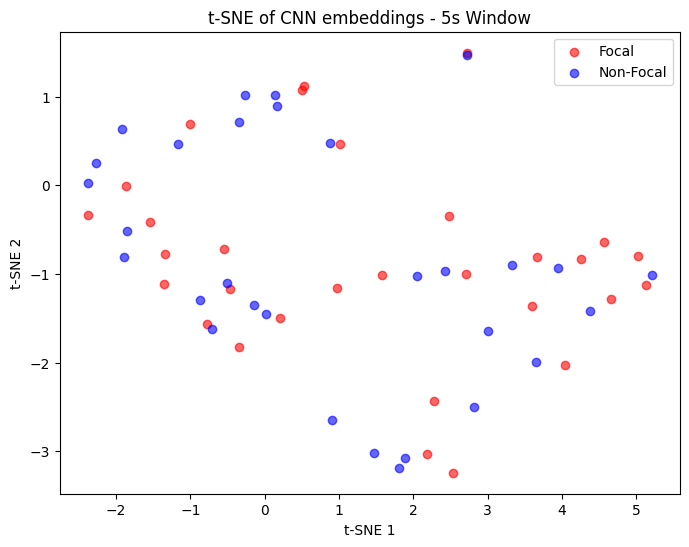


=== Window: 6s (3072 samples) ===
Epoch 1: train_acc=0.50, val_acc=0.50
Epoch 2: train_acc=0.53, val_acc=0.50
Epoch 3: train_acc=0.56, val_acc=0.57
Epoch 4: train_acc=0.59, val_acc=0.48
Epoch 5: train_acc=0.59, val_acc=0.52
Epoch 6: train_acc=0.54, val_acc=0.57
Epoch 7: train_acc=0.51, val_acc=0.57
Epoch 8: train_acc=0.61, val_acc=0.58
Epoch 9: train_acc=0.66, val_acc=0.60
Epoch 10: train_acc=0.62, val_acc=0.58


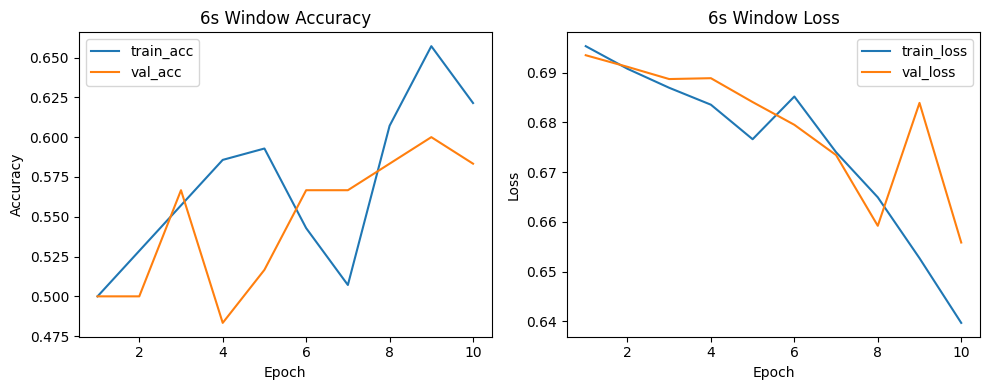

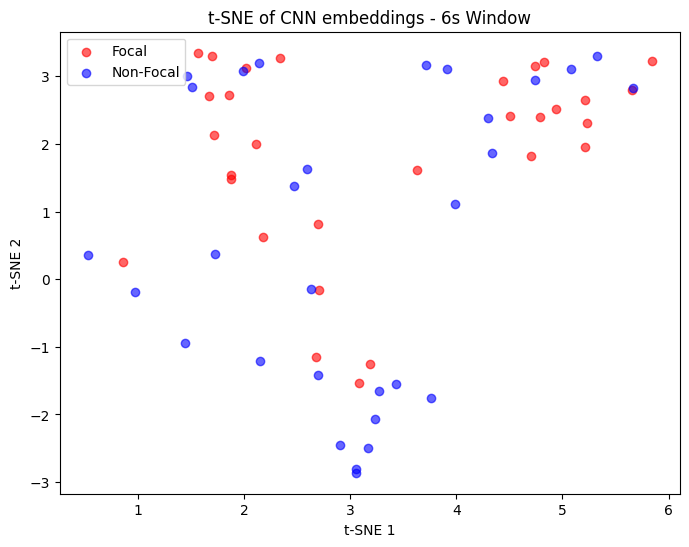


=== Window: 7s (3584 samples) ===
Epoch 1: train_acc=0.51, val_acc=0.55
Epoch 2: train_acc=0.58, val_acc=0.57
Epoch 3: train_acc=0.57, val_acc=0.57
Epoch 4: train_acc=0.59, val_acc=0.58
Epoch 5: train_acc=0.60, val_acc=0.58
Epoch 6: train_acc=0.61, val_acc=0.63
Epoch 7: train_acc=0.61, val_acc=0.62
Epoch 8: train_acc=0.58, val_acc=0.63
Epoch 9: train_acc=0.59, val_acc=0.63
Epoch 10: train_acc=0.62, val_acc=0.58


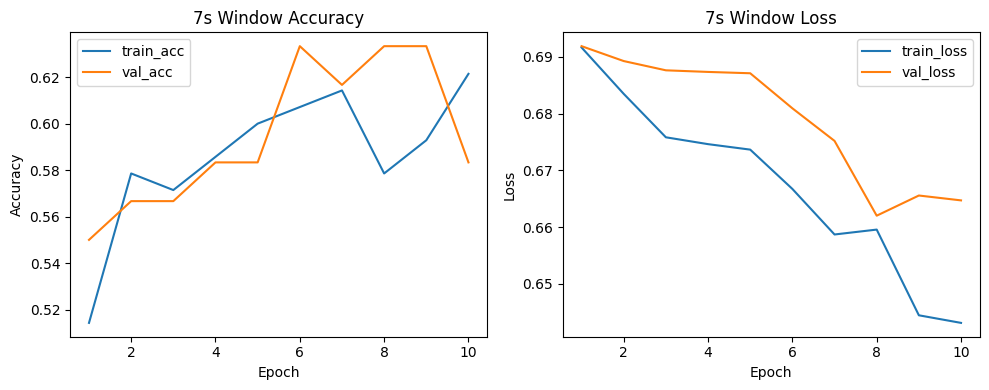

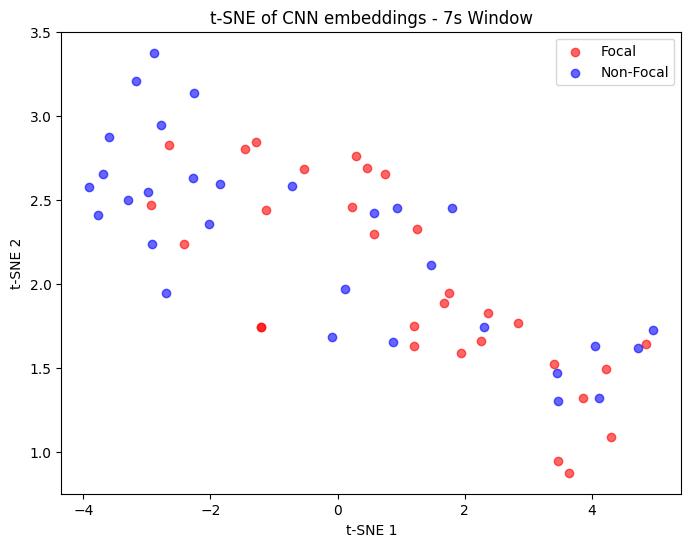


=== Window: 8s (4096 samples) ===
Epoch 1: train_acc=0.46, val_acc=0.50
Epoch 2: train_acc=0.51, val_acc=0.50
Epoch 3: train_acc=0.58, val_acc=0.58
Epoch 4: train_acc=0.55, val_acc=0.52
Epoch 5: train_acc=0.56, val_acc=0.58
Epoch 6: train_acc=0.56, val_acc=0.57
Epoch 7: train_acc=0.54, val_acc=0.62
Epoch 8: train_acc=0.59, val_acc=0.63
Epoch 9: train_acc=0.62, val_acc=0.63
Epoch 10: train_acc=0.60, val_acc=0.63


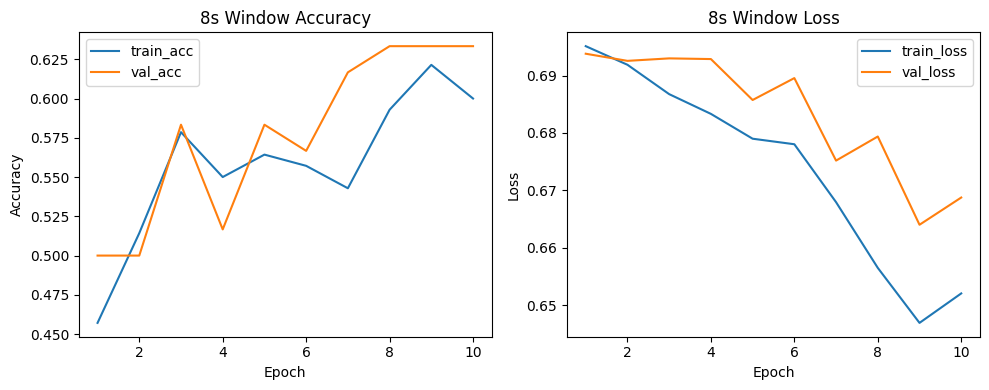

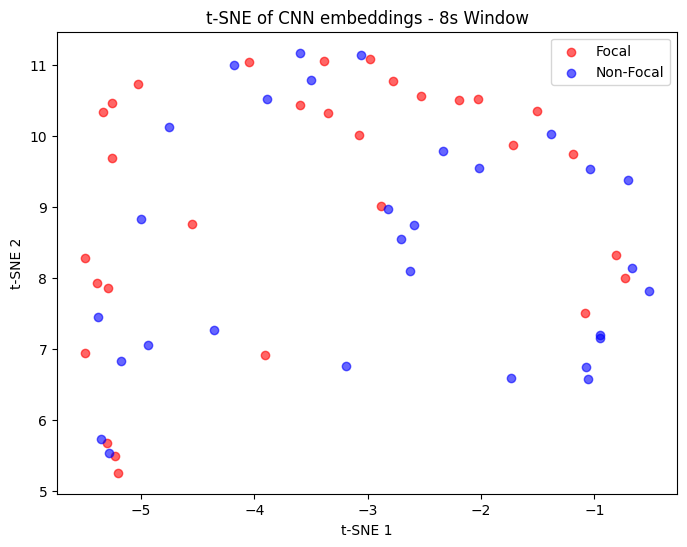


=== Window: 9s (4608 samples) ===
Epoch 1: train_acc=0.46, val_acc=0.50
Epoch 2: train_acc=0.61, val_acc=0.53
Epoch 3: train_acc=0.64, val_acc=0.58
Epoch 4: train_acc=0.64, val_acc=0.57
Epoch 5: train_acc=0.71, val_acc=0.48
Epoch 6: train_acc=0.69, val_acc=0.57
Epoch 7: train_acc=0.69, val_acc=0.55
Epoch 8: train_acc=0.72, val_acc=0.62
Epoch 9: train_acc=0.76, val_acc=0.63
Epoch 10: train_acc=0.74, val_acc=0.63


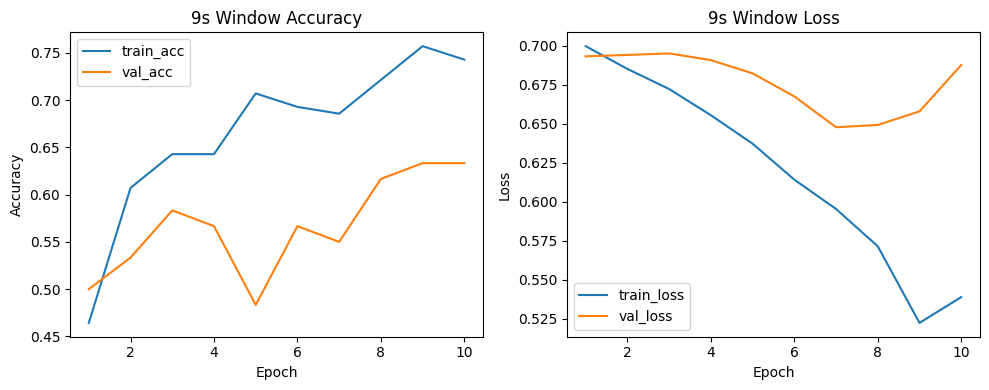

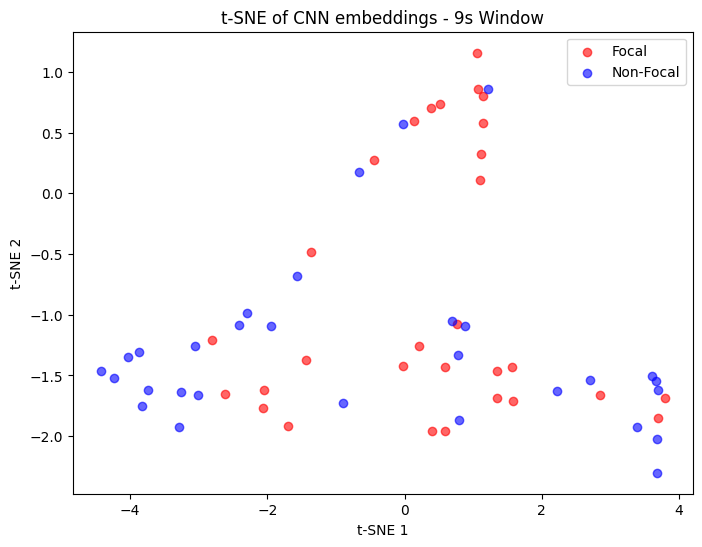


=== Window: 10s (5120 samples) ===
Epoch 1: train_acc=0.45, val_acc=0.52
Epoch 2: train_acc=0.55, val_acc=0.52
Epoch 3: train_acc=0.58, val_acc=0.53
Epoch 4: train_acc=0.54, val_acc=0.55
Epoch 5: train_acc=0.57, val_acc=0.57
Epoch 6: train_acc=0.57, val_acc=0.55
Epoch 7: train_acc=0.64, val_acc=0.58
Epoch 8: train_acc=0.64, val_acc=0.53
Epoch 9: train_acc=0.65, val_acc=0.50
Epoch 10: train_acc=0.55, val_acc=0.57


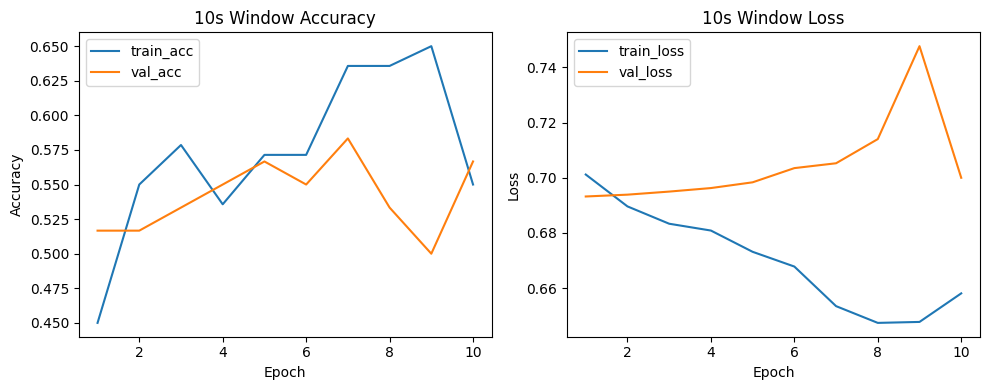

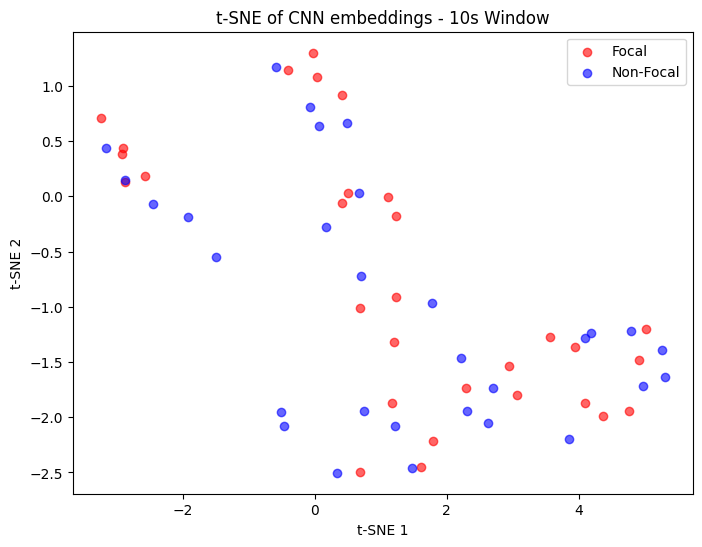

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
SAMPLING_RATE = 512
WINDOW_SECONDS_LIST = list(range(3, 11))  # 3s to 10s
EXAMPLES_PER_CLASS = 100  # 200 examples total
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment function
def segment_rows(data, window_size):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L < window_size:
            continue
        start = np.random.randint(0, L - window_size + 1)  # random segment for sanity check
        segmented.append(row[start:start+window_size])
    return np.array(segmented, dtype=np.float32)

# -------------------------
# Normalize per-window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx][np.newaxis, :]  # (1, seq_len)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# -------------------------
# CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64*2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, channels=1, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last timestep
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))
        return out.squeeze()

    def get_embeddings(self, x):
        # Same as forward, but returns embedding after fc1 + ReLU (before final layer)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        return x  # embedding shape (batch, 32)

# -------------------------
# Training & evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    preds, labels = [], []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds.append(out.detach().cpu())
        labels.append(y_batch.detach().cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds>=0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds.append(out.cpu())
            labels.append(y_batch.cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds>=0.5).astype(int))
    return running_loss / len(loader.dataset), acc

# -------------------------
# Extract embeddings from dataset
def get_embeddings_and_labels(model, loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            emb = model.get_embeddings(X_batch).cpu().numpy()
            embeddings.append(emb)
            labels.append(y_batch.numpy())
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

# -------------------------
# t-SNE plot
def plot_tsne(embeddings, labels, window_sec):
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(emb_2d[labels==1, 0], emb_2d[labels==1, 1], label='Focal', alpha=0.6, color='red')
    plt.scatter(emb_2d[labels==0, 0], emb_2d[labels==0, 1], label='Non-Focal', alpha=0.6, color='blue')
    plt.title(f"t-SNE of CNN embeddings - {window_sec}s Window")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.show()

# -------------------------
# Main training loop for different window sizes
results = {}
for sec in WINDOW_SECONDS_LIST:
    window_len = sec * SAMPLING_RATE
    print(f"\n=== Window: {sec}s ({window_len} samples) ===")
    focal_seg = segment_rows(focal, window_len)
    non_focal_seg = segment_rows(non_focal, window_len)
   
    # Shuffle and select 100 examples per class
    idx_f = np.random.permutation(len(focal_seg))[:EXAMPLES_PER_CLASS]
    idx_nf = np.random.permutation(len(non_focal_seg))[:EXAMPLES_PER_CLASS]
    X = np.vstack((focal_seg[idx_f], non_focal_seg[idx_nf]))
    y = np.array([1]*EXAMPLES_PER_CLASS + [0]*EXAMPLES_PER_CLASS)
   
    # Shuffle dataset
    perm = np.random.permutation(len(y))
    X, y = X[perm], y[perm]
   
    X = normalize_windows_per_window(X)
   
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    train_ds = EEGDataset(X_train, y_train)
    val_ds = EEGDataset(X_val, y_val)
   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
   
    model = CNN_BiLSTM(input_len=window_len).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
   
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print(f"Epoch {epoch}: train_acc={train_acc:.2f}, val_acc={val_acc:.2f}")
   
    # Store results
    results[sec] = {
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "train_loss": train_loss_list,
        "val_loss": val_loss_list
    }
   
    # Plot accuracy and loss curves
    epochs_range = range(1, EPOCHS+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_acc_list, label="train_acc")
    plt.plot(epochs_range, val_acc_list, label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{sec}s Window Accuracy")
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_loss_list, label="train_loss")
    plt.plot(epochs_range, val_loss_list, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{sec}s Window Loss")
    plt.legend()
   
    plt.tight_layout()
    plt.show()

    # Extract embeddings and plot t-SNE
    embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
    plot_tsne(embeddings, val_labels, sec)



=== Window: 5s (2560 samples) ===
Epoch 001: train_acc=0.5808, val_acc=0.5572
Epoch 010: train_acc=0.6932, val_acc=0.7082
Epoch 020: train_acc=0.7807, val_acc=0.7659
Epoch 030: train_acc=0.8033, val_acc=0.7977
Epoch 040: train_acc=0.8249, val_acc=0.8036
Epoch 050: train_acc=0.8413, val_acc=0.8003
Epoch 060: train_acc=0.8561, val_acc=0.8026
Epoch 070: train_acc=0.8739, val_acc=0.7980
Epoch 080: train_acc=0.8889, val_acc=0.7892
Epoch 090: train_acc=0.9077, val_acc=0.7917
Epoch 100: train_acc=0.9178, val_acc=0.7906


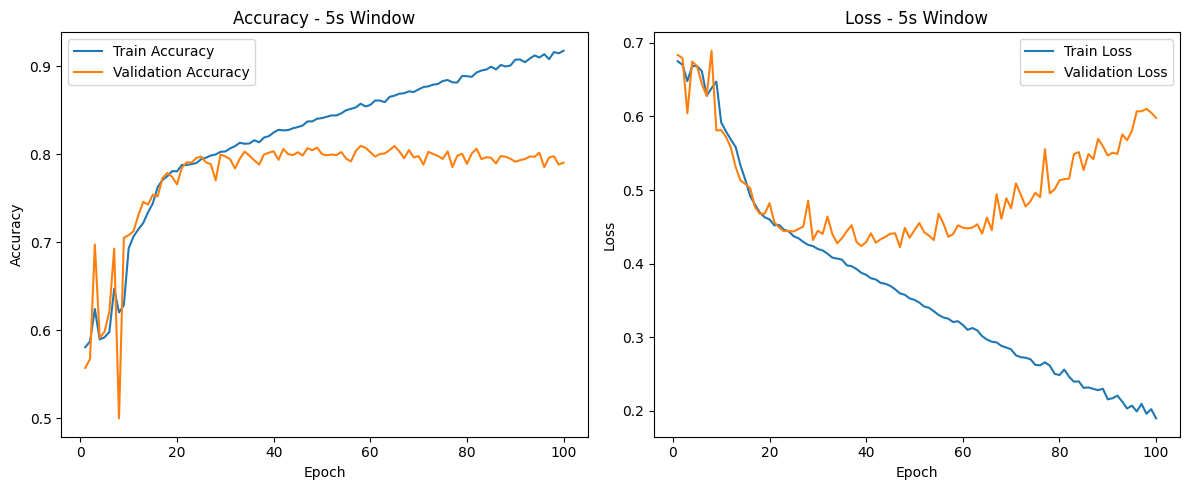


=== Window: 6s (3072 samples) ===
Epoch 001: train_acc=0.5785, val_acc=0.5089
Epoch 010: train_acc=0.6474, val_acc=0.6990
Epoch 020: train_acc=0.7767, val_acc=0.7799
Epoch 030: train_acc=0.8076, val_acc=0.7956
Epoch 040: train_acc=0.8243, val_acc=0.7941
Epoch 050: train_acc=0.8399, val_acc=0.8079
Epoch 060: train_acc=0.8579, val_acc=0.7959
Epoch 070: train_acc=0.8709, val_acc=0.7999
Epoch 080: train_acc=0.8862, val_acc=0.7916
Epoch 090: train_acc=0.8981, val_acc=0.7947
Epoch 100: train_acc=0.9142, val_acc=0.7921


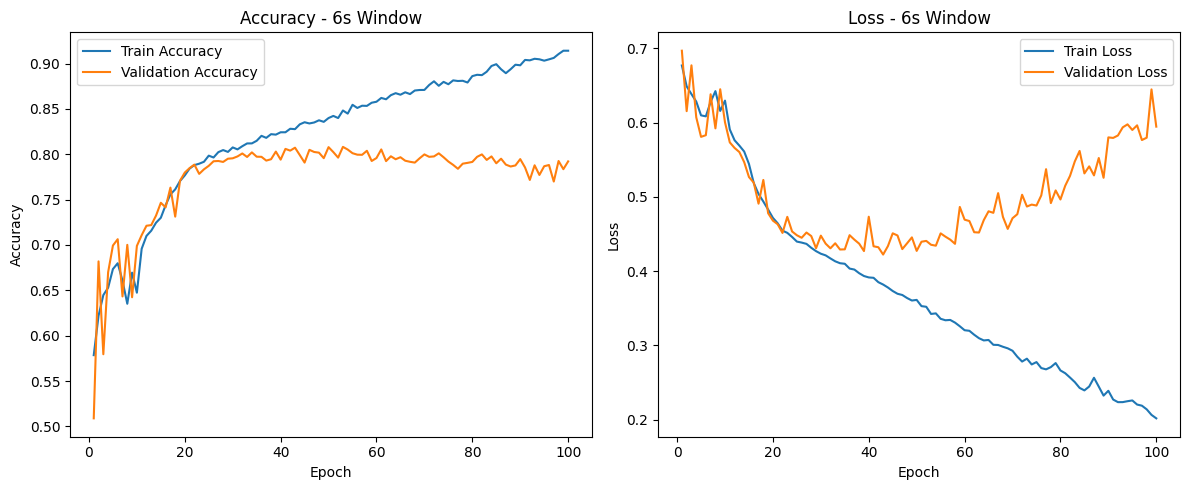


=== Window: 7s (3584 samples) ===
Epoch 001: train_acc=0.5256, val_acc=0.5958
Epoch 010: train_acc=0.7336, val_acc=0.7449
Epoch 020: train_acc=0.7930, val_acc=0.7818
Epoch 030: train_acc=0.8125, val_acc=0.7991
Epoch 040: train_acc=0.8292, val_acc=0.7958
Epoch 050: train_acc=0.8480, val_acc=0.7898
Epoch 060: train_acc=0.8706, val_acc=0.8044
Epoch 070: train_acc=0.8866, val_acc=0.7862
Epoch 080: train_acc=0.9050, val_acc=0.7871
Epoch 090: train_acc=0.9270, val_acc=0.7896
Epoch 100: train_acc=0.9354, val_acc=0.7862


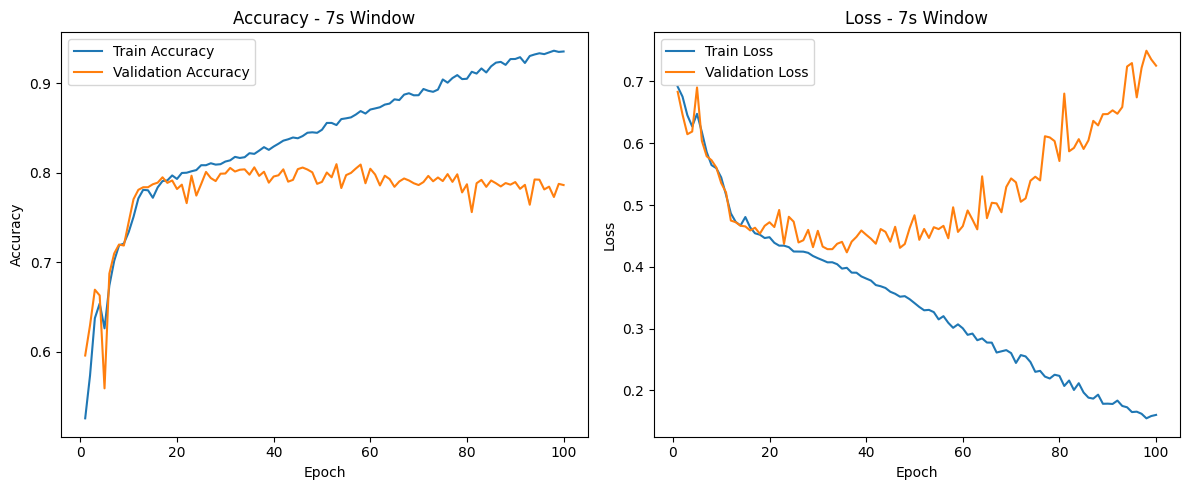


=== Window: 8s (4096 samples) ===
Epoch 001: train_acc=0.5716, val_acc=0.5018
Epoch 010: train_acc=0.7206, val_acc=0.6936
Epoch 020: train_acc=0.7886, val_acc=0.7807
Epoch 030: train_acc=0.8100, val_acc=0.7944
Epoch 040: train_acc=0.8264, val_acc=0.7989
Epoch 050: train_acc=0.8450, val_acc=0.8051
Epoch 060: train_acc=0.8571, val_acc=0.8024
Epoch 070: train_acc=0.8733, val_acc=0.8018
Epoch 080: train_acc=0.8948, val_acc=0.7693
Epoch 090: train_acc=0.9017, val_acc=0.8002
Epoch 100: train_acc=0.9143, val_acc=0.7727


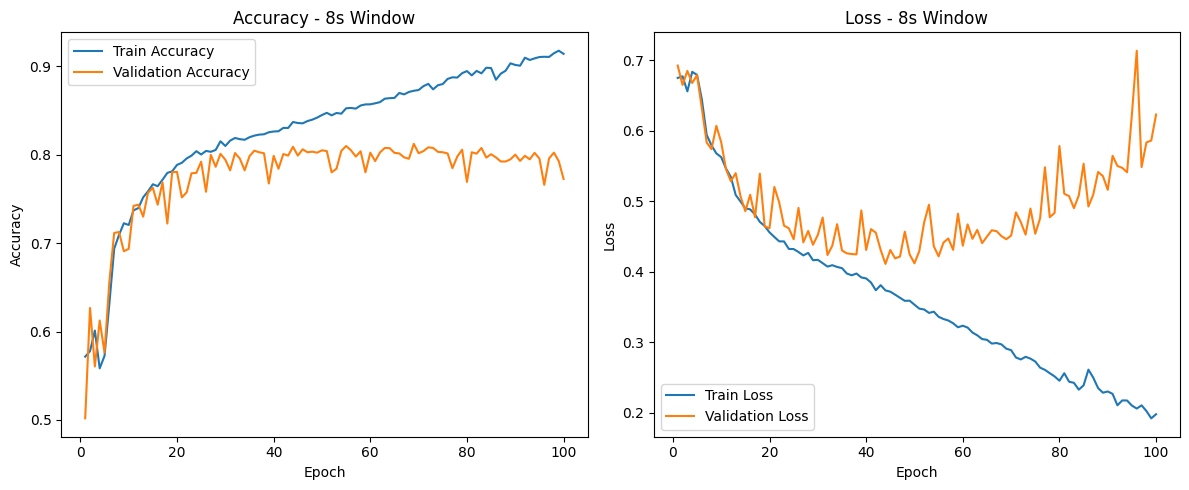


=== Window: 9s (4608 samples) ===
Epoch 001: train_acc=0.5681, val_acc=0.5936
Epoch 010: train_acc=0.7265, val_acc=0.7280
Epoch 020: train_acc=0.7644, val_acc=0.7636
Epoch 030: train_acc=0.8027, val_acc=0.7867
Epoch 040: train_acc=0.8113, val_acc=0.7791
Epoch 050: train_acc=0.8294, val_acc=0.7929
Epoch 060: train_acc=0.8562, val_acc=0.7829
Epoch 070: train_acc=0.8788, val_acc=0.7869
Epoch 080: train_acc=0.9014, val_acc=0.7729
Epoch 090: train_acc=0.9068, val_acc=0.7722
Epoch 100: train_acc=0.9339, val_acc=0.7747


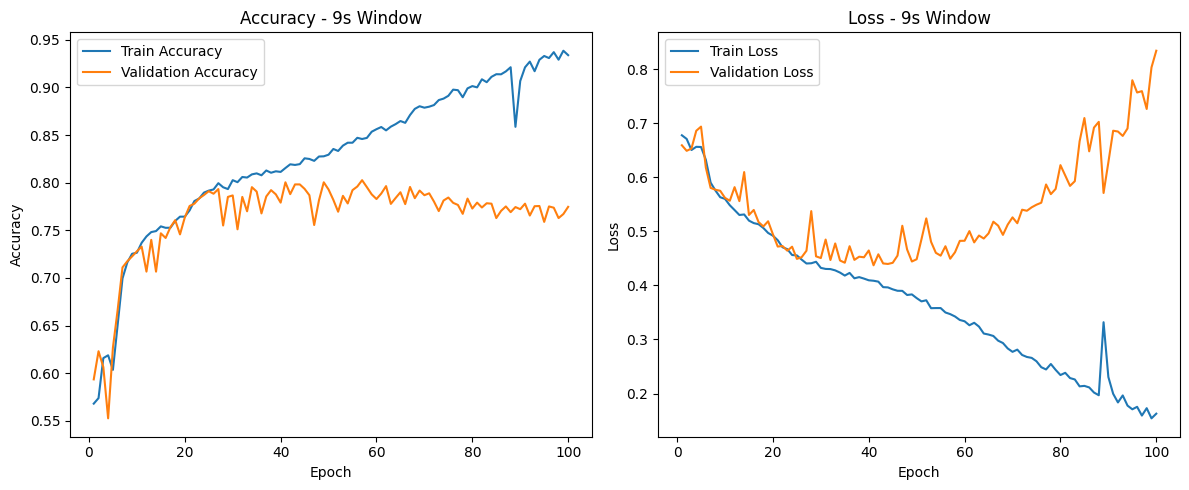

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
SAMPLING_RATE = 512
WINDOW_SECONDS_LIST = [5,6,7,8,9]  # Only 7s and 9s windows
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment function
def segment_rows(data, window_size):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L < window_size:
            continue
        # Extract ALL possible non-overlapping windows from the row
        # or randomly sample windows to cover entire data better
        # Here, we'll slide with stride = window_size (non-overlapping)
        for start in range(0, L - window_size + 1, window_size):
            segmented.append(row[start:start+window_size])
    return np.array(segmented, dtype=np.float32)

# -------------------------
# Normalize per-window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx][np.newaxis, :]  # (1, seq_len)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# -------------------------
# CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64*2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))
        return out.squeeze()

# -------------------------
# Training & evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    preds, labels = [], []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds.append(out.detach().cpu())
        labels.append(y_batch.detach().cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds.append(out.cpu())
            labels.append(y_batch.cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

# -------------------------
# Main training loop for window sizes 7s and 9s
results = {}
for sec in WINDOW_SECONDS_LIST:
    window_len = sec * SAMPLING_RATE
    print(f"\n=== Window: {sec}s ({window_len} samples) ===")

    # Segment data fully (non-overlapping windows)
    focal_seg = segment_rows(focal, window_len)
    non_focal_seg = segment_rows(non_focal, window_len)

    # Combine datasets
    X = np.vstack((focal_seg, non_focal_seg))
    y = np.array([1]*len(focal_seg) + [0]*len(non_focal_seg))

    # Normalize windows
    X = normalize_windows_per_window(X)

    # Split train/val 70/30 stratified
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

    train_ds = EEGDataset(X_train, y_train)
    val_ds = EEGDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, criterion, optimizer
    model = CNN_BiLSTM(input_len=window_len).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
            print(f"Epoch {epoch:03d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    # Store results for this window size
    results[sec] = {
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "train_loss": train_loss_list,
        "val_loss": val_loss_list
    }

    # Plot training curves
    epochs_range = range(1, EPOCHS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
    plt.plot(epochs_range, val_acc_list, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - {sec}s Window")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss_list, label="Train Loss")
    plt.plot(epochs_range, val_loss_list, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {sec}s Window")
    plt.legend()

    plt.tight_layout()
    plt.show()



=== Window: 9s (4608 samples) ===
Epoch 001: train_acc=0.5186, val_acc=0.5000
Epoch 010: train_acc=0.5630, val_acc=0.6347
Epoch 020: train_acc=0.6114, val_acc=0.6202
Epoch 030: train_acc=0.6786, val_acc=0.6847
Epoch 040: train_acc=0.7091, val_acc=0.6942
Epoch 050: train_acc=0.7522, val_acc=0.7191
Epoch 060: train_acc=0.7953, val_acc=0.7944
Epoch 070: train_acc=0.8122, val_acc=0.7982
Epoch 080: train_acc=0.8277, val_acc=0.8062
Epoch 090: train_acc=0.8315, val_acc=0.8096
Epoch 100: train_acc=0.8384, val_acc=0.8020
Epoch 110: train_acc=0.8494, val_acc=0.7962
Epoch 120: train_acc=0.8530, val_acc=0.8047
Epoch 130: train_acc=0.8641, val_acc=0.8071
Epoch 140: train_acc=0.8717, val_acc=0.7969
Epoch 150: train_acc=0.8783, val_acc=0.8024
Epoch 160: train_acc=0.8844, val_acc=0.8049
Epoch 170: train_acc=0.8865, val_acc=0.8033
Epoch 180: train_acc=0.8969, val_acc=0.7842
Epoch 190: train_acc=0.8973, val_acc=0.7969
Epoch 200: train_acc=0.9039, val_acc=0.7958
Epoch 210: train_acc=0.9075, val_acc=0.79

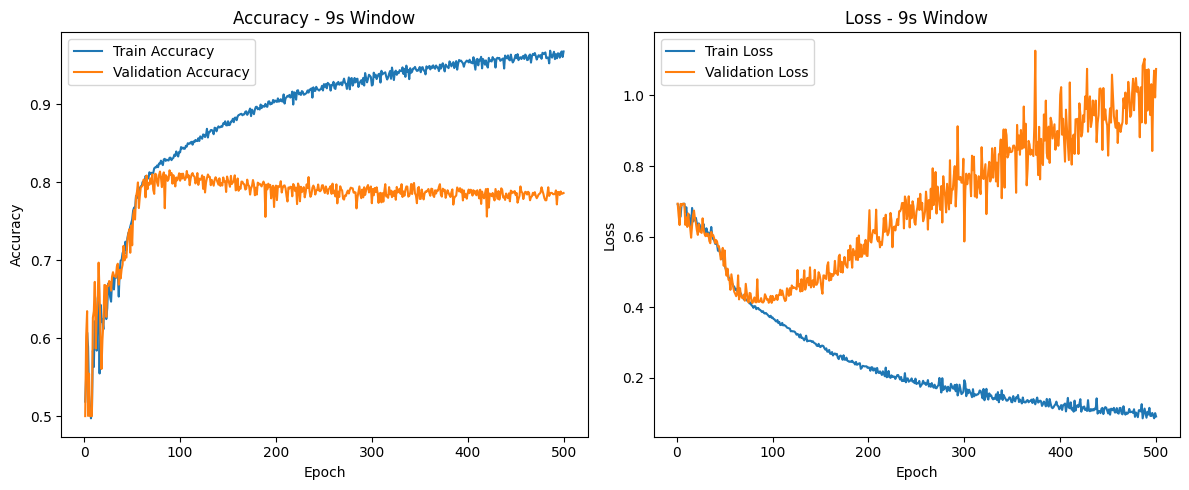

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -------------------------
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
SAMPLING_RATE = 512
WINDOW_SECONDS = 9   # fixed at 9s
BATCH_SIZE = 16
EPOCHS = 500
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load data
focal = pd.read_csv(FOCAL_PATH, header=None).values
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values

# -------------------------
# Segment function
def segment_rows(data, window_size):
    segmented = []
    for row in data:
        row = np.asarray(row, dtype=np.float32)
        L = len(row)
        if L < window_size:
            continue
        for start in range(0, L - window_size + 1, window_size):
            segmented.append(row[start:start+window_size])
    return np.array(segmented, dtype=np.float32)

# -------------------------
# Normalize per-window
def normalize_windows_per_window(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

# -------------------------
# PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx][np.newaxis, :]  # (1, seq_len)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# -------------------------
# CNN + BiLSTM with Dropout + BatchNorm
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_len, dropout_p=0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64*2, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # dropout before final output
        out = self.sigmoid(self.fc2(x))
        return out.squeeze()

# -------------------------
# Training & evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    preds, labels = [], []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        preds.append(out.detach().cpu())
        labels.append(y_batch.detach().cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds.append(out.cpu())
            labels.append(y_batch.cpu())
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

# -------------------------
# Main training loop for 9s window
window_len = WINDOW_SECONDS * SAMPLING_RATE
print(f"\n=== Window: {WINDOW_SECONDS}s ({window_len} samples) ===")

# Segment data fully (non-overlapping windows)
focal_seg = segment_rows(focal, window_len)
non_focal_seg = segment_rows(non_focal, window_len)

# Combine datasets
X = np.vstack((focal_seg, non_focal_seg))
y = np.array([1]*len(focal_seg) + [0]*len(non_focal_seg))

# Normalize windows
X = normalize_windows_per_window(X)

# Split train/val 70/30 stratified
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

train_ds = EEGDataset(X_train, y_train)
val_ds = EEGDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, criterion, optimizer
model = CNN_BiLSTM(input_len=window_len, dropout_p=0.5).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
        print(f"Epoch {epoch:03d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    # Early stopping condition
    if val_acc > 0.85 and train_acc > 0.90:
        print(f"Stopping early at epoch {epoch} (train_acc={train_acc:.4f}, val_acc={val_acc:.4f})")
        break

# Plot training curves
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Accuracy - {WINDOW_SECONDS}s Window")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label="Train Loss")
plt.plot(epochs_range, val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss - {WINDOW_SECONDS}s Window")
plt.legend()

plt.tight_layout()
plt.show()




focal shape: (3750, 10240) non_focal shape: (3750, 10240)
After filter focal, non_focal: (3750, 10240) (3750, 10240)
Train/Val sizes: 5250 2250
CNN+BiLSTM parameter count: 669473
CNN_BiLSTM Epoch 001 t=1.6s train_loss=0.5772 train_acc=0.6977 val_loss=0.8131 val_acc=0.5080 lr=1.00e-03
CNN_BiLSTM Epoch 002 t=1.6s train_loss=0.5524 train_acc=0.7301 val_loss=0.6363 val_acc=0.6467 lr=1.00e-03
CNN_BiLSTM Epoch 003 t=1.6s train_loss=0.5014 train_acc=0.7684 val_loss=0.6205 val_acc=0.6022 lr=1.00e-03
CNN_BiLSTM Epoch 004 t=1.6s train_loss=0.4713 train_acc=0.7813 val_loss=0.7108 val_acc=0.5787 lr=1.00e-03
CNN_BiLSTM Epoch 005 t=1.6s train_loss=0.4515 train_acc=0.7907 val_loss=0.7297 val_acc=0.5498 lr=1.00e-03
CNN_BiLSTM Epoch 006 t=1.6s train_loss=0.4298 train_acc=0.8088 val_loss=0.7172 val_acc=0.5596 lr=1.00e-03
CNN_BiLSTM Epoch 007 t=1.6s train_loss=0.4458 train_acc=0.7998 val_loss=0.7306 val_acc=0.5129 lr=1.00e-03
CNN_BiLSTM Epoch 008 t=1.5s train_loss=0.4268 train_acc=0.8095 val_loss=0.5840 

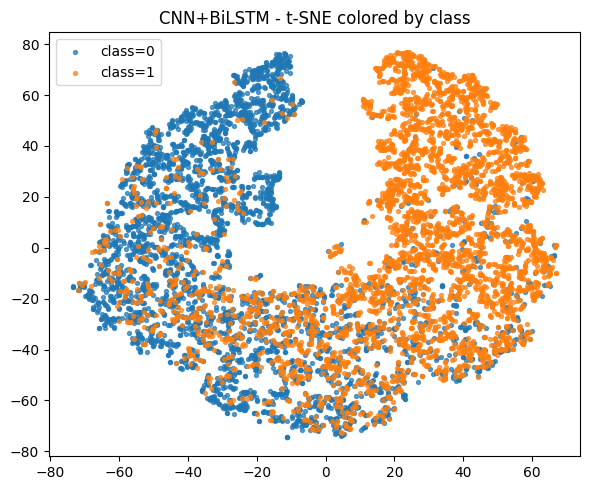

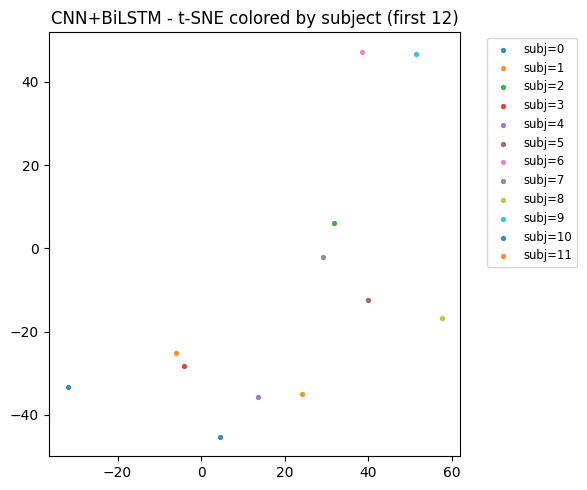

Running t-SNE on features (this may take a while)...
t-SNE done in 14.613193035125732 s


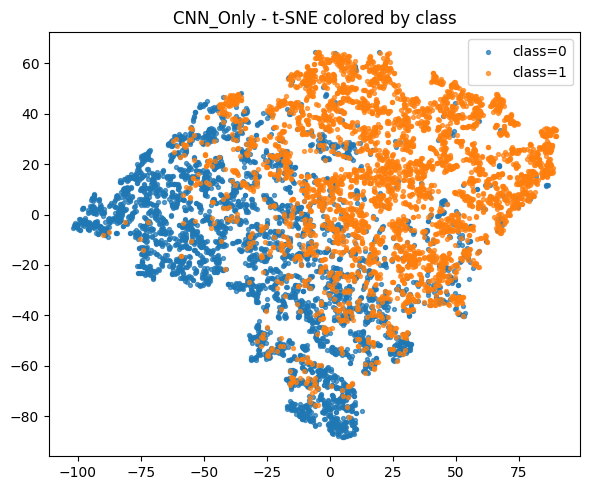

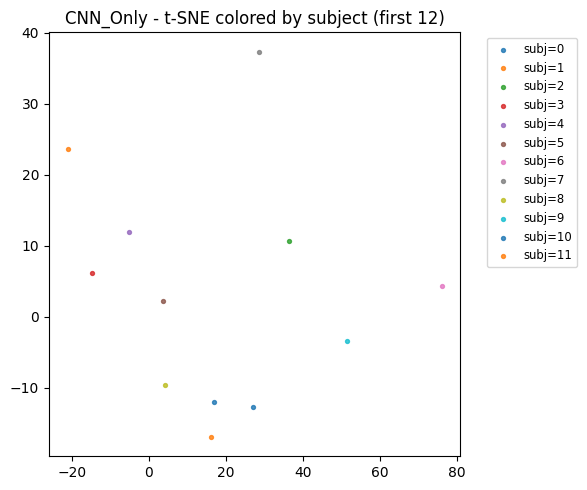

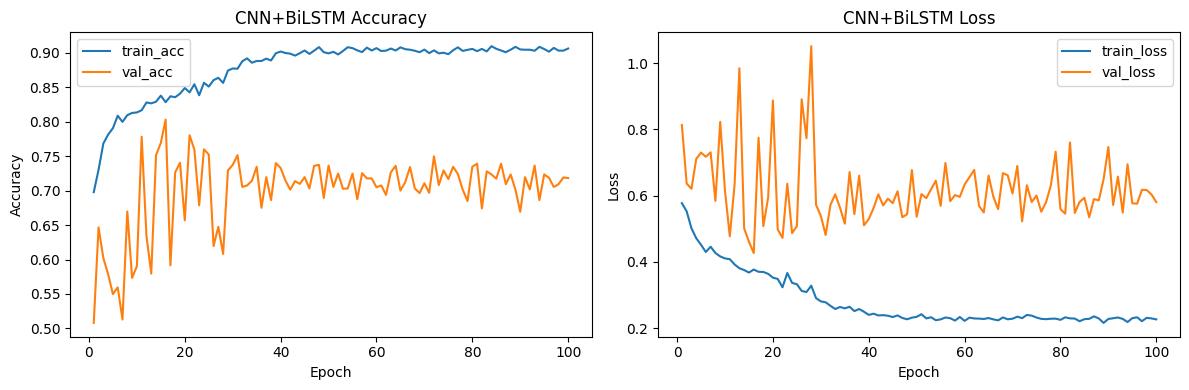

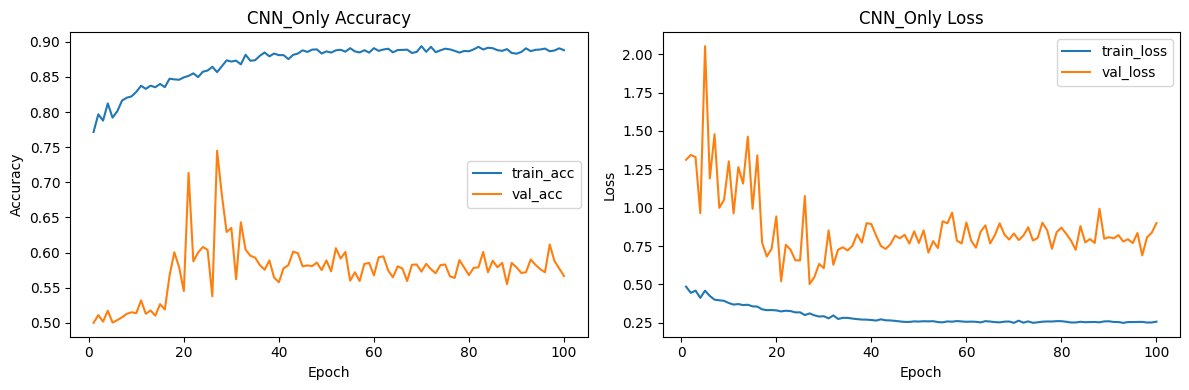

Done training & plotting.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import time
import random

# -------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# -------------------------
# Parameters (change as needed)
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
SAMPLING_RATE = 512
ROW_LEN = 10240           # entire row length (you said 10,240)
BATCH_SIZE = 32           # larger batch for stable BatchNorm
EPOCHS = 100              # you can increase
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 12             # early stopping patience on val_loss
REDUCE_LR_PATIENCE = 4    # for ReduceLROnPlateau
MIN_DELTA = 1e-4

# -------------------------
# Load data (each row is full recording; we will use full ROW_LEN)
focal = pd.read_csv(FOCAL_PATH, header=None).values.astype(np.float32)
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values.astype(np.float32)

# Quick-check shapes (you expect rows x 10240)
print("focal shape:", focal.shape, "non_focal shape:", non_focal.shape)

# If some rows are longer than ROW_LEN, truncate; if shorter, skip or pad (we'll skip here)
def filter_and_trim_rows(arr, target_len=ROW_LEN):
    rows = []
    for r in arr:
        if len(r) < target_len:
            # skip short rows — optionally you can pad instead
            continue
        rows.append(r[:target_len])
    return np.stack(rows, axis=0) if len(rows) > 0 else np.empty((0, target_len), dtype=np.float32)

focal = filter_and_trim_rows(focal, ROW_LEN)
non_focal = filter_and_trim_rows(non_focal, ROW_LEN)
print("After filter focal, non_focal:", focal.shape, non_focal.shape)

# Combine and form labels and subject/row ids
n_focal_rows = focal.shape[0]
n_non_rows = non_focal.shape[0]
X = np.vstack([focal, non_focal])           # shape (N, ROW_LEN)
y = np.array([1]*n_focal_rows + [0]*n_non_rows, dtype=np.int64)
subject_ids = np.array(list(range(n_focal_rows)) + [i for i in range(n_focal_rows, n_focal_rows+n_non_rows)])

# Normalize per-row (zero-mean unit std) — keep as in prior code
def normalize_per_row(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

X = normalize_per_row(X)

# -------------------------
# Train/Val split (random stratified at row-level)
X_train, X_val, y_train, y_val, subj_train, subj_val = train_test_split(
    X, y, subject_ids, test_size=0.3, random_state=SEED, stratify=y)

print("Train/Val sizes:", X_train.shape[0], X_val.shape[0])

# -------------------------
# Dataset & DataLoader
class EEGFullRowDataset(Dataset):
    def __init__(self, X, y, subj_ids=None, augment=False):
        self.X = X
        self.y = y
        self.subj_ids = subj_ids if subj_ids is not None else np.zeros(len(y), dtype=int)
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            # small augmentations (gaussian noise, slight scaling, time shift)
            if np.random.rand() < 0.5:
                x = x + np.random.normal(0, 0.01, size=x.shape).astype(np.float32)
            if np.random.rand() < 0.3:
                scale = np.random.uniform(0.95, 1.05)
                x = (x * scale).astype(np.float32)
            if np.random.rand() < 0.2:
                shift = np.random.randint(-100, 100)
                x = np.roll(x, shift)
        x = x[np.newaxis, :]  # (1, ROW_LEN)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), int(self.subj_ids[idx])

train_ds = EEGFullRowDataset(X_train, y_train, subj_train, augment=True)
val_ds = EEGFullRowDataset(X_val, y_val, subj_val, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Model architectures
# We'll implement a shared Conv feature extractor and two heads.

class ConvFeatureExtractor(nn.Module):
    def __init__(self, in_channels=1, dropout_p=0.3):
        super().__init__()
        # Conv blocks: Conv1d -> BatchNorm -> ReLU -> Dropout -> MaxPool
        # We'll downsample aggressively so LSTM sees manageable seq length
        self.block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=11, padding=5, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool1d(kernel_size=4)   # /4
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=9, padding=4, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool1d(kernel_size=4)   # /4 -> /16
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool1d(kernel_size=2)   # /2 -> /32
        )
        self.block4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool1d(kernel_size=2)   # /2 -> /64
        )
        # After these four blocks the downsampling factor = 4*4*2*2 = 64
        # For ROW_LEN=10240 -> seq_len_after = 10240/64 = 160 timesteps (approx).
        # Good for feeding LSTM.

    def forward(self, x):
        # x: (batch, 1, ROW_LEN)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x  # (batch, channels=256, seq_len_reduced)

# CNN + BiLSTM head
class CNN_BiLSTM_Full(nn.Module):
    def __init__(self, dropout_p=0.3, lstm_hidden=128, lstm_layers=1):
        super().__init__()
        self.fe = ConvFeatureExtractor(in_channels=1, dropout_p=dropout_p)
        self.lstm_hidden = lstm_hidden
        self.lstm = nn.LSTM(input_size=256, hidden_size=lstm_hidden, num_layers=lstm_layers,
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc_out = nn.Linear(128, 1)  # logits

    def forward(self, x):
        # x: (batch, 1, ROW_LEN)
        x = self.fe(x)  # (batch, 256, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features=256)
        out, _ = self.lstm(x)   # (batch, seq_len, 2*lstm_hidden)
        out = out[:, -1, :]     # last timestep representation
        out = self.fc1(out)
        out = self.bn_fc(out)
        out = torch.relu(out)
        out = self.dropout(out)
        logits = self.fc_out(out).squeeze(-1)  # (batch,)
        return logits

    def extract_features(self, x):
        # returns penultimate features (after fc1, before final fc)
        x = self.fe(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        feat = self.fc1(out)
        feat = self.bn_fc(feat)
        feat = torch.relu(feat)
        return feat.detach().cpu().numpy()  # numpy array

# CNN-only classifier
class CNN_Only(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.fe = ConvFeatureExtractor(in_channels=1, dropout_p=dropout_p)
        # global pooling then FC
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # collapse time -> (batch, channels, 1)
        self.fc1 = nn.Linear(256, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc_out = nn.Linear(128, 1)  # logits

    def forward(self, x):
        x = self.fe(x)  # (batch, 256, seq_len)
        x = self.global_pool(x).squeeze(-1)  # (batch, 256)
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc_out(x).squeeze(-1)
        return logits

    def extract_features(self, x):
        x = self.fe(x)
        x = self.global_pool(x).squeeze(-1)
        feat = self.fc1(x)
        feat = self.bn_fc(feat)
        feat = torch.relu(feat)
        return feat.detach().cpu().numpy()

# -------------------------
# Helper training / evaluation functions (works for both models)
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []
    for Xb, yb, _ in loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds_all.append(probs)
        labels_all.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds_all)
    labels = np.concatenate(labels_all)
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for Xb, yb, _ in loader:
            Xb = Xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(Xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * Xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds_all.append(probs)
            labels_all.append(yb.cpu().numpy())
    preds = np.concatenate(preds_all)
    labels = np.concatenate(labels_all)
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

# -------------------------
# Utility: function to train a model with ReduceLROnPlateau + early stopping and return history + best model
def run_training(model, train_loader, val_loader, model_name="model"):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                     patience=REDUCE_LR_PATIENCE)
    best_val_loss = float('inf')
    best_state = None

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_model(model, val_loader, criterion)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"{model_name} Epoch {epoch:03d} t={time.time()-t0:.1f}s "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]['lr']:.2e}")

    # Load best state before returning
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

# -------------------------
# Train CNN+BiLSTM
cnn_bl_model = CNN_BiLSTM_Full(dropout_p=0.35, lstm_hidden=128, lstm_layers=1)
print("CNN+BiLSTM parameter count:", sum(p.numel() for p in cnn_bl_model.parameters()))
cnn_bl_model, history_bl = run_training(cnn_bl_model, train_loader, val_loader, model_name="CNN_BiLSTM")

# -------------------------
# Train CNN-only
cnn_only_model = CNN_Only(dropout_p=0.35)
print("CNN-Only parameter count:", sum(p.numel() for p in cnn_only_model.parameters()))
cnn_only_model, history_cnn = run_training(cnn_only_model, train_loader, val_loader, model_name="CNN_Only")

# -------------------------
# Feature extraction (penultimate layer) for train+val combined
def extract_features_for_dataset(model, dataset, batch_size=64):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    feats = []
    labels = []
    subj = []
    with torch.no_grad():
        for Xb, yb, sb in loader:
            Xb = Xb.to(DEVICE)
            f = model.extract_features(Xb)  # returns numpy
            feats.append(f)
            labels.append(yb.numpy())
            subj.extend(sb)
    feats = np.vstack(feats)
    labels = np.concatenate(labels)
    subj = np.array(subj)
    return feats, labels, subj

# combine full dataset order same as earlier splitting? We'll create dataset objects for the full X,y
full_ds = EEGFullRowDataset(X, y, subject_ids, augment=False)
feats_bl, labels_full, subj_full = extract_features_for_dataset(cnn_bl_model, full_ds, batch_size=64)
feats_cnn, _, _ = extract_features_for_dataset(cnn_only_model, full_ds, batch_size=64)

print("Extracted features shapes:", feats_bl.shape, feats_cnn.shape)

# -------------------------
# t-SNE (can be slow). We'll run with PCA initialization to speed up.
def run_tsne_and_plot(feats, labels, subj, title_prefix="Model"):
    print("Running t-SNE on features (this may take a while)...")
    t0 = time.time()
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=SEED, learning_rate='auto')
    z = tsne.fit_transform(feats)
    print("t-SNE done in", time.time()-t0, "s")

    # Plot by class
    plt.figure(figsize=(6,5))
    for cls in np.unique(labels):
        mask = labels == cls
        plt.scatter(z[mask,0], z[mask,1], label=f"class={int(cls)}", s=8, alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} - t-SNE colored by class")
    plt.tight_layout()
    plt.show()

    # Plot by subject (limit number of subjects shown for readability)
    unique_subj = np.unique(subj)
    max_subj_to_plot = 12
    chosen_subj = unique_subj[:max_subj_to_plot]
    plt.figure(figsize=(6,5))
    for s in chosen_subj:
        mask = subj == s
        plt.scatter(z[mask,0], z[mask,1], label=f"subj={int(s)}", s=8, alpha=0.8)
    plt.title(f"{title_prefix} - t-SNE colored by subject (first {max_subj_to_plot})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

# Run t-SNE for both models (features extracted above)
run_tsne_and_plot(feats_bl, labels_full, subj_full, title_prefix="CNN+BiLSTM")
run_tsne_and_plot(feats_cnn, labels_full, subj_full, title_prefix="CNN_Only")

# -------------------------
# Plot training curves: accuracy and loss for both models
def plot_history(history, model_name="model"):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_bl, model_name="CNN+BiLSTM")
plot_history(history_cnn, model_name="CNN_Only")

# -------------------------
# Save models (optional)
torch.save(cnn_bl_model.state_dict(), "cnn_bilstm_full.pth")
torch.save(cnn_only_model.state_dict(), "cnn_only.pth")

print("Done training & plotting.")



In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

# -------------------------
# Save training history to CSV
def save_history_to_csv(history, filename):
    df = pd.DataFrame({
        "epoch": np.arange(1, len(history['train_loss']) + 1),
        "train_loss": history["train_loss"],
        "train_acc": history["train_acc"],
        "val_loss": history["val_loss"],
        "val_acc": history["val_acc"],
    })
    df.to_csv(filename, index=False)
    print(f"[✔] Saved training history to {filename}")

# -------------------------
# Save training curves as PNG
def plot_history_and_save(history, model_name="model", filename="plot.png"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"[✔] Saved training plot to {filename}")

# -------------------------
# Save t-SNE plots
def run_tsne_and_save(feats, labels, subj, title_prefix="Model", out_prefix="model"):
    print(f"[...] Running t-SNE for {out_prefix} (may take some time)...")
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42, learning_rate='auto')
    z = tsne.fit_transform(feats)

    # Plot by class
    plt.figure(figsize=(6, 5))
    for cls in np.unique(labels):
        mask = labels == cls
        plt.scatter(z[mask, 0], z[mask, 1], label=f"class={int(cls)}", s=8, alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} - t-SNE by class")
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_tsne_by_class.png", dpi=300)
    plt.close()
    print(f"[✔] Saved t-SNE (class) plot to {out_prefix}_tsne_by_class.png")

    # Plot by subject (first 12 only)
    unique_subj = np.unique(subj)
    chosen_subj = unique_subj[:12]
    plt.figure(figsize=(6, 5))
    for s in chosen_subj:
        mask = subj == s
        plt.scatter(z[mask, 0], z[mask, 1], label=f"subj={int(s)}", s=8, alpha=0.8)
    plt.title(f"{title_prefix} - t-SNE by subject (first 12)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_tsne_by_subject.png", dpi=300)
    plt.close()
    print(f"[✔] Saved t-SNE (subject) plot to {out_prefix}_tsne_by_subject.png")

# -------------------------
# Execute all saves using existing in-memory variables

# === Save training history ===
save_history_to_csv(history_bl, "cnn_bilstm_history.csv")
save_history_to_csv(history_cnn, "cnn_only_history.csv")

# === Save training plots ===
plot_history_and_save(history_bl, model_name="CNN+BiLSTM", filename="cnn_bilstm_plot.png")
plot_history_and_save(history_cnn, model_name="CNN_Only", filename="cnn_only_plot.png")

# === Save t-SNE plots ===
run_tsne_and_save(feats_bl, labels_full, subj_full, title_prefix="CNN+BiLSTM", out_prefix="cnn_bilstm")
run_tsne_and_save(feats_cnn, labels_full, subj_full, title_prefix="CNN_Only", out_prefix="cnn_only")

print("\n✅ All plots and CSVs saved.")


[✔] Saved training history to cnn_bilstm_history.csv
[✔] Saved training history to cnn_only_history.csv
[✔] Saved training plot to cnn_bilstm_plot.png
[✔] Saved training plot to cnn_only_plot.png
[...] Running t-SNE for cnn_bilstm (may take some time)...
[✔] Saved t-SNE (class) plot to cnn_bilstm_tsne_by_class.png
[✔] Saved t-SNE (subject) plot to cnn_bilstm_tsne_by_subject.png
[...] Running t-SNE for cnn_only (may take some time)...
[✔] Saved t-SNE (class) plot to cnn_only_tsne_by_class.png
[✔] Saved t-SNE (subject) plot to cnn_only_tsne_by_subject.png

✅ All plots and CSVs saved.


After filter focal/non_focal shapes: (3750, 10240) (3750, 10240)
Train/val counts: 5250 2250
Params CNN+BiLSTM: 709185
CNN_BiLSTM_Deep Epoch 001 t=2.1s train_loss=0.6076 train_acc=0.6749 val_loss=0.9133 val_acc=0.5027 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 002 t=2.1s train_loss=0.5412 train_acc=0.7387 val_loss=0.7722 val_acc=0.5591 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 003 t=2.1s train_loss=0.5449 train_acc=0.7297 val_loss=0.7063 val_acc=0.6018 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 004 t=2.1s train_loss=0.5178 train_acc=0.7484 val_loss=0.5448 val_acc=0.7338 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 005 t=2.1s train_loss=0.4907 train_acc=0.7779 val_loss=0.6822 val_acc=0.5747 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 006 t=2.1s train_loss=0.4600 train_acc=0.7922 val_loss=0.6195 val_acc=0.5987 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 007 t=2.1s train_loss=0.4509 train_acc=0.7922 val_loss=0.7460 val_acc=0.5551 lr=1.0e-03
CNN_BiLSTM_Deep Epoch 008 t=2.1s train_loss=0.4358 train_acc=0.8036 val_loss=0.5136 val_acc=0.7307 lr=1.0e-03
C

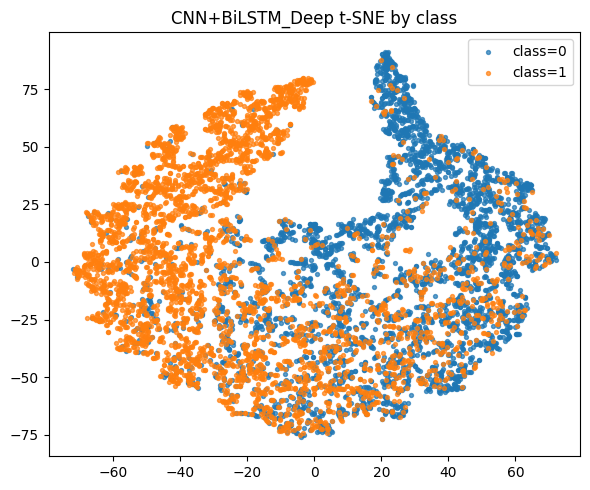

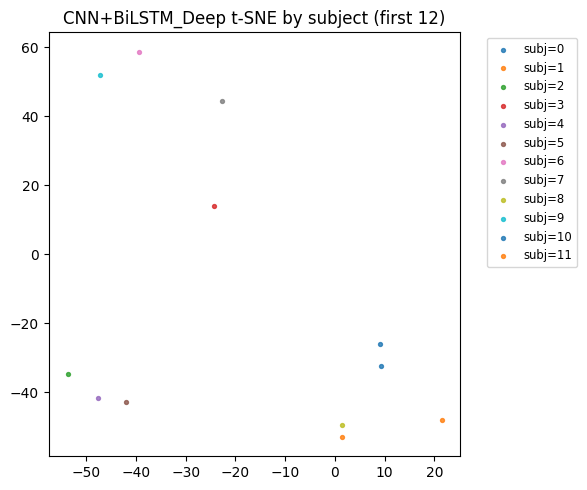

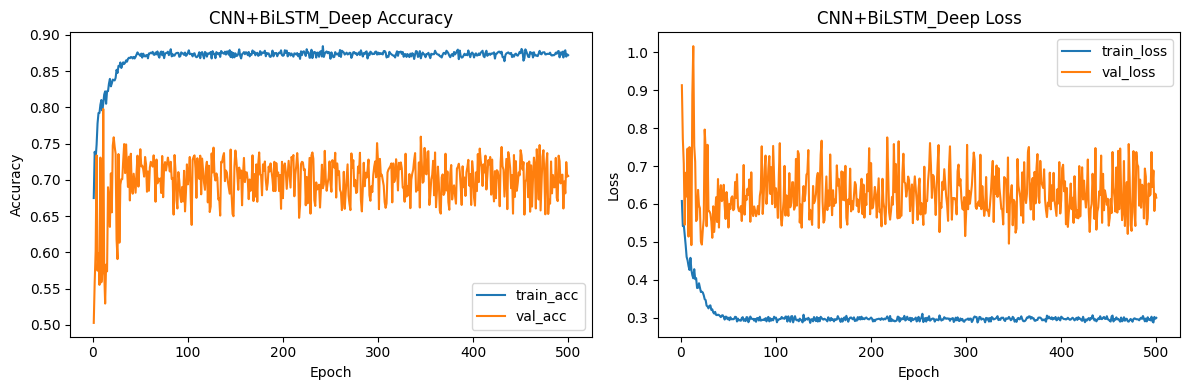

Done.


In [7]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# -------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# -------------------------
# Parameters
DATA_DIR = "Bern Barcelona"
FOCAL_PATH = os.path.join(DATA_DIR, "focal.csv")
NON_FOCAL_PATH = os.path.join(DATA_DIR, "non_focal.csv")
ROW_LEN = 10240
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3   # stronger regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REDUCE_LR_PATIENCE = 4
MIN_DELTA = 1e-4

# -------------------------
# Load and filter data
focal = pd.read_csv(FOCAL_PATH, header=None).values.astype(np.float32)
non_focal = pd.read_csv(NON_FOCAL_PATH, header=None).values.astype(np.float32)

def filter_and_trim_rows(arr, target_len=ROW_LEN):
    rows = []
    for r in arr:
        if len(r) < target_len:
            continue
        rows.append(r[:target_len])
    return np.stack(rows, axis=0) if len(rows) > 0 else np.empty((0, target_len), dtype=np.float32)

focal = filter_and_trim_rows(focal, ROW_LEN)
non_focal = filter_and_trim_rows(non_focal, ROW_LEN)
print("After filter focal/non_focal shapes:", focal.shape, non_focal.shape)

# Combine
n_focal = focal.shape[0]
n_non = non_focal.shape[0]
X = np.vstack([focal, non_focal])
y = np.array([1]*n_focal + [0]*n_non, dtype=np.int64)
subject_ids = np.arange(len(y))  # placeholder; replace with real subject IDs if available

# Normalize each row
def normalize_per_row(X):
    means = X.mean(axis=1, keepdims=True)
    stds = X.std(axis=1, keepdims=True)
    stds[stds == 0] = 1.0
    return (X - means) / stds

X = normalize_per_row(X)

# Train/val split (stratified)
X_train, X_val, y_train, y_val, subj_train, subj_val = train_test_split(
    X, y, subject_ids, test_size=0.3, random_state=SEED, stratify=y)

print("Train/val counts:", X_train.shape[0], X_val.shape[0])

# -------------------------
# Dataset
class EEGFullRowDataset(Dataset):
    def __init__(self, X, y, subj_ids=None, augment=False):
        self.X = X
        self.y = y
        self.subj_ids = subj_ids if subj_ids is not None else np.zeros(len(y), dtype=int)
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx].copy()
        if self.augment:
            if np.random.rand() < 0.5:
                x = x + np.random.normal(0, 0.01, size=x.shape).astype(np.float32)
            if np.random.rand() < 0.3:
                scale = np.random.uniform(0.95, 1.05)
                x = (x * scale).astype(np.float32)
            if np.random.rand() < 0.2:
                shift = np.random.randint(-200, 200)
                x = np.roll(x, shift)
        x = x[np.newaxis, :]  # add channel dim
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), int(self.subj_ids[idx])

train_ds = EEGFullRowDataset(X_train, y_train, subj_train, augment=True)
val_ds = EEGFullRowDataset(X_val, y_val, subj_val, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Feature extractor
class ConvFeatureExtractor(nn.Module):
    def __init__(self, in_channels=1, dropout_p=0.4):
        super().__init__()
        def conv_block(in_ch, out_ch, kernel, pool_k, dropout_p):
            return nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=kernel, padding=kernel//2, bias=False),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.MaxPool1d(pool_k)
            )
        self.b1 = conv_block(1, 64, kernel=5, pool_k=4, dropout_p=dropout_p)
        self.b2 = conv_block(64, 128, kernel=3, pool_k=4, dropout_p=dropout_p)
        self.b3 = conv_block(128, 192, kernel=3, pool_k=2, dropout_p=dropout_p)
        self.b4 = conv_block(192, 256, kernel=3, pool_k=2, dropout_p=dropout_p)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        return x  # (B, 256, seq_len_reduced)

# -------------------------
# CNN+BiLSTM model
class CNN_BiLSTM_Deep(nn.Module):
    def __init__(self, dropout_p=0.4, lstm_hidden=128, lstm_layers=1):
        super().__init__()
        self.fe = ConvFeatureExtractor(in_channels=1, dropout_p=dropout_p)
        self.lstm = nn.LSTM(input_size=256, hidden_size=lstm_hidden, num_layers=lstm_layers,
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(256, 1)

    def forward(self, x):
        x = self.fe(x)                 # (B, 256, seq_len)
        x = x.permute(0, 2, 1)         # (B, seq_len, 256)
        out, _ = self.lstm(x)
        out = out[:, -1, :]            # last timestep
        out = self.fc1(out)
        out = self.bn_fc(out)
        out = torch.relu(out)
        out = self.dropout(out)
        logits = self.fc_out(out).squeeze(-1)
        return logits

    def extract_features(self, x):
        with torch.no_grad():
            x = self.fe(x)
            x = x.permute(0, 2, 1)
            out, _ = self.lstm(x)
            out = out[:, -1, :]
            feat = self.fc1(out)
            feat = self.bn_fc(feat)
            feat = torch.relu(feat)
        return feat.cpu().numpy()

# -------------------------
# Training utilities
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    preds, labels = [], []
    for Xb, yb, _ in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds.append(probs)
        labels.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds, labels = [], []
    with torch.no_grad():
        for Xb, yb, _ in loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            logits = model(Xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * Xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.append(probs)
            labels.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    acc = accuracy_score(labels, (preds >= 0.5).astype(int))
    return running_loss / len(loader.dataset), acc

def run_training(model, model_name, train_loader, val_loader, epochs=EPOCHS):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=REDUCE_LR_PATIENCE)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"{model_name} Epoch {epoch:03d} t={time.time()-t0:.1f}s "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]['lr']:.1e}")
    return model, history

# -------------------------
# Train model
model_bl = CNN_BiLSTM_Deep(dropout_p=0.4, lstm_hidden=128)
print("Params CNN+BiLSTM:", sum(p.numel() for p in model_bl.parameters()))
model_bl, hist_bl = run_training(model_bl, "CNN_BiLSTM_Deep", train_loader, val_loader)

# -------------------------
# Feature extraction for t-SNE
def extract_features(model, X_all, batch_size=64):
    model.eval()
    ds = EEGFullRowDataset(X_all, np.zeros(len(X_all), dtype=int), subj_ids=None, augment=False)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    feats = []
    with torch.no_grad():
        for Xb, _, _ in loader:
            Xb = Xb.to(DEVICE)
            feat = model.extract_features(Xb)
            feats.append(feat)
    return np.vstack(feats)

X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])
subj_all = np.concatenate([subj_train, subj_val])
feats_bl = extract_features(model_bl, X_all)
print("Feature shape:", feats_bl.shape)

# -------------------------
# t-SNE plotting
def plot_tsne(feats, labels, subj, title_prefix="model"):
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=SEED, learning_rate='auto')
    z = tsne.fit_transform(feats)
    plt.figure(figsize=(6,5))
    for cls in np.unique(labels):
        mask = labels == cls
        plt.scatter(z[mask,0], z[mask,1], label=f"class={int(cls)}", s=8, alpha=0.7)
    plt.legend(); plt.title(f"{title_prefix} t-SNE by class")
    plt.tight_layout(); plt.show()
    unique_subj = np.unique(subj)
    max_plot = min(12, len(unique_subj))
    chosen = unique_subj[:max_plot]
    plt.figure(figsize=(6,5))
    for s in chosen:
        mask = subj == s
        plt.scatter(z[mask,0], z[mask,1], label=f"subj={int(s)}", s=8, alpha=0.8)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.title(f"{title_prefix} t-SNE by subject (first {max_plot})")
    plt.tight_layout(); plt.show()

plot_tsne(feats_bl, y_all, subj_all, title_prefix="CNN+BiLSTM_Deep")

# -------------------------
# Plot training curves
def plot_history(hist, name):
    epochs = range(1, len(hist['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['train_acc'], label='train_acc')
    plt.plot(epochs, hist['val_acc'], label='val_acc')
    plt.title(f"{name} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['train_loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title(f"{name} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.tight_layout(); plt.show()

plot_history(hist_bl, "CNN+BiLSTM_Deep")

# Save model
torch.save(model_bl.state_dict(), "cnn_bilstm_deep.pth")
print("Done.")
